<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Stochastic_Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We load the neccessary libraries, specifiy the domain $z \in [0,1]$ and the differentiation matrices $D = d/dz$ and $L = d^2/dz^2$.

In [124]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

ε    = 1e-12
Npts = 64

z = np.linspace(0+ε,1-ε,Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dQ}{dz} &= 2 \sqrt{\pi} \alpha M^{1/2}, \\
\frac{dM}{dz} &= \frac{F Q}{M}, \\
\frac{dF}{dz} &= -\frac{d b}{d z} Q,
\end{align*}
where $F(z), Q(z)$ and $M(z)$ are the horizontally averaged (steady) buoyancy flux, volume flux and momentum flux respectively. This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the entrainment coefficient $\alpha$. As the role of this parameter will change depending on the plume height we use the model
\begin{equation}
\alpha = -\frac{3}{8}\delta + \frac{1}{4}\frac{F Q^2}{M^{5/2}},
\end{equation}
where $\delta < 0$ is the dimensionless turbulence production coefficient and the second term is proportional to the Richardson number $Ri$. Using this entrainment model the plume equations are implemented below.

In [125]:
def plume_eqns(z,X,dbdz,δ):

    F,Q,M = X

    α    = -(3/8)*δ + (1/4)*( (F * Q**2)/M**2.5 )

    dFdz = -dbdz(z)*Q;
    dQdz = 2*α*np.sqrt(np.pi)*(M**0.5)
    dMdz = (F*Q)/M

    return [dFdz,dQdz,dMdz]

To solve these equations we first set up an ode solver using scipy, which for a rising plume takes as initial conditions
\begin{align*}
Q(z=0) &= Q_0, \\
M(z=0) &= M_0, \\
F(z=0) &= P_{F|Q}(f|q=Q_0,z=0) = \mathcal{N}(\mu=F_0,\sigma^2)
\end{align*}
where the buoyancy flux is drawn from a normal distribution centered around $F_0$ with variance ??. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$, which requires making the transform $z \to 1-z$ and then integrating from $z=1 \to 0$ until $F=0$. \\

As $F(z=0,1)$ is given by a distribution, we make use of a Monte-Carlo approach in order to obtain the average solution. This consists of running whereby a large ensemble of initial conditions and then averaging over the ensemble of solutions.

In [131]:
def Plume_Solve(F0,Nsq,δ=-0.25):

    # zero crossing
    def event(t,y,*args): return y[0];
    event.terminal = True;
    event.positive = 0

    # Flip the stratifictaion around
    if F0 < 0:
      Nsq = Nsq[::-1]

    # Solver
    dbdz = interp1d(z,Nsq,fill_value="extrapolate")
    sol  = solve_ivp(fun=plume_eqns,t_span=[z[0],z[-1]], y0=[abs(F0),ε,ε], t_eval=z,args=(dbdz,δ),events=event,rtol=1e-03,atol=1e-06)

    # Parse into entire domain
    F = 0.*z;
    Q = 0.*z;
    if F0 > 0.:
      F[0:len(sol.y[0])] = sol.y[0]
      Q[0:len(sol.y[1])] = sol.y[1]
    elif F0 < 0.:
      F[Npts-len(sol.y[0]):] =     sol.y[0][::-1]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][::-1]

    return F,Q

def N(μ=0,σ=.1,samples = 10**2):

  """
  Generate N_samples from a Normal distribution

  N(μ,σ2)

  of mean μ and standard deviation σ.

  """

  return np.random.default_rng().normal(loc=μ,scale=σ,size=samples)

def Plume_Solve_Distribution(F0,Nsq,samples = 10**2):

  # Get the samples
  std_dev = (abs(F0)/10.) # 10% of the mean
  μ       = F0
  F_0     = N(μ=μ,σ=std_dev,samples=samples)

  # print('Checking distribution mu,std_dev=',abs(μ - np.mean(F_0)),abs(std_dev - np.std(F_0) ))
  # plt.hist(F_0, bins=30, density=True)
  # plt.show()

  # Containers for the solution
  Q = 0*z
  F = 0*z

  for f_0 in F_0:
    Fi,Qi  = Plume_Solve(f_0,Nsq)
    F+=Fi; Q+=Qi

  F /=samples
  Q /=samples

  return F,Q


Generate rising and descending plumes

In [ ]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;

# Initial conditions
Nsq    = 4*z
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

We now repeat this process except for initial conditions drawn from a normal distribution of mean $F_i$ and standard deviation 10% of the mean.

In [ ]:
# Initial conditions
Nsq    = 4*z
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Distribution(F_value,Nsq,samples = 10**2)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \sigma \frac{\partial^2 b}{\partial z^2},
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
and $\sigma$ a regularising diffusion. To do solve we implement the advection diffusion equation with and without a regularising diffusion for buoyancy $b(z,t)$ as below

In [101]:
def step_buoyancy(w,b,σ=.1,dt=1e-03,A_inv = None, B = None):

    """
    Step forward using one time-step

    if σ > 0:
    Crank-Nicolson
    elif σ == 0
    Euler-Explicit

    returns b(z,t_n+1)
    """

    if σ > 0:

      if (A_inv is None) and (B is None):
        A = (I/dt - .5*σ*L)
        B = (I/dt + .5*σ*L)
        return np.linalg.solve(A,B@b - w*(D@b) )
      else:
        return A_inv@( B@b - w*(D@b) )

    elif σ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*dt)/dz > 1.:
        dt *=0.5

      return b - dt*w*(D@b)

With a solver developed for the plume equations and for the 1D buoyancy equations we now link these routines together to establish the background stratification profile for a given set of plume sources and sinks. We consider the case of two opposing plumes of equal strength. \\

We first specify initial conditions for the rising plume
\begin{align}
  F_1(z=0) &= 1, \\
  Q_1(z=0) &= 0, \\
  M_1(z=0) &= 0,
\end{align}
the sinking plume
\begin{align}
  F_2(z=1) &=-1, \\
  Q_2(z=1) &= 0, \\
  M_2(z=1) &= 0,
\end{align}
and the initial stratification
\begin{equation}
  db/dz(z,t_0=0) = 1.
\end{equation}
Using these boundary conditions we then:
- Solve the plume equations using $db/dz(z,t_n)$ for each of the plumes to obtain $Q_i^n$
- Compute $\bar{w}(z,t_n)$ from the sum of the plumes' volume fluxes $Q_i^n$
- Timestep the 1D buoyancy equation forward from $t_n \to t_n + dt$ to update $db/dz(z,t_n)$ \\

This process is repeated until the residual error
\begin{equation}
  || db^{n+1}/dz - db^{n}/dz ||_2/||db^{n}/dz || < \text{tol},
\end{equation}
falls below a user prescribed tolerance.

Iteration i = 10, Residual error r_i = 1.323037e-03 



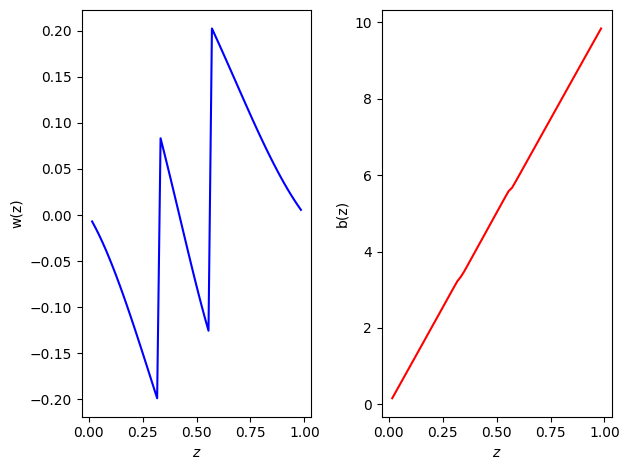

Iteration i = 20, Residual error r_i = 1.258918e-03 



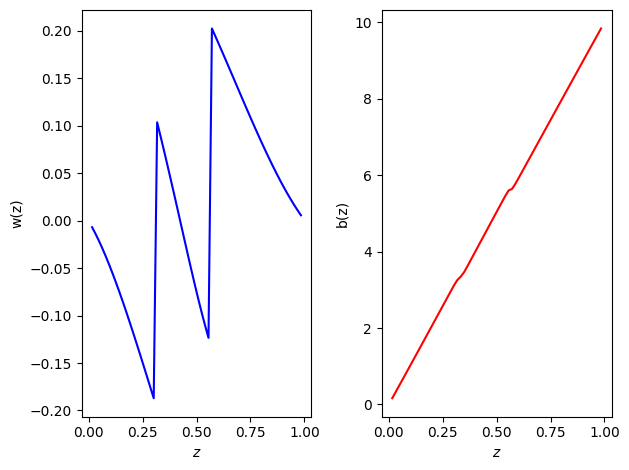

Iteration i = 30, Residual error r_i = 1.108975e-03 



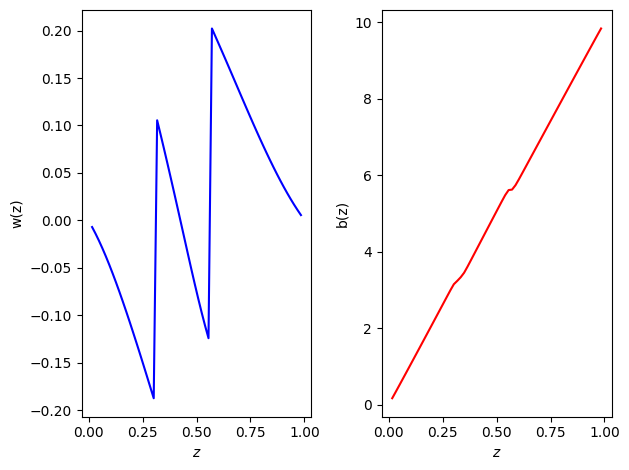

Iteration i = 40, Residual error r_i = 1.241430e-03 



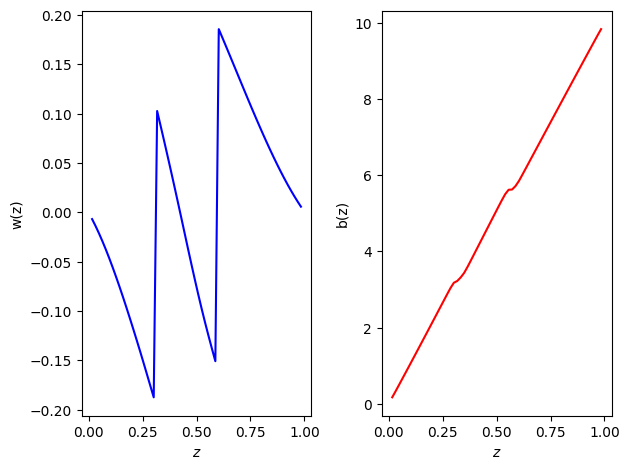

Iteration i = 50, Residual error r_i = 1.054807e-03 



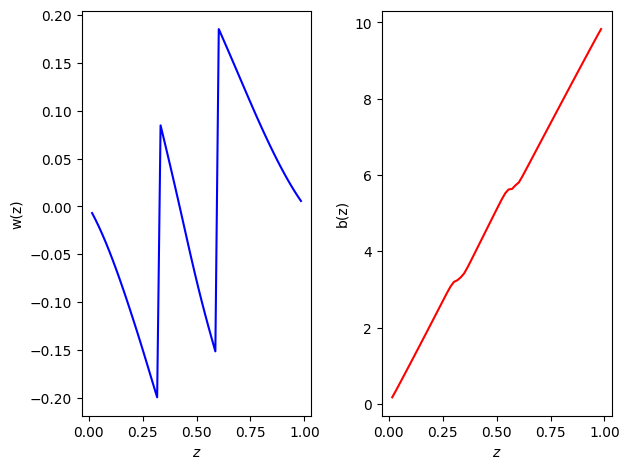

Iteration i = 60, Residual error r_i = 8.704731e-04 



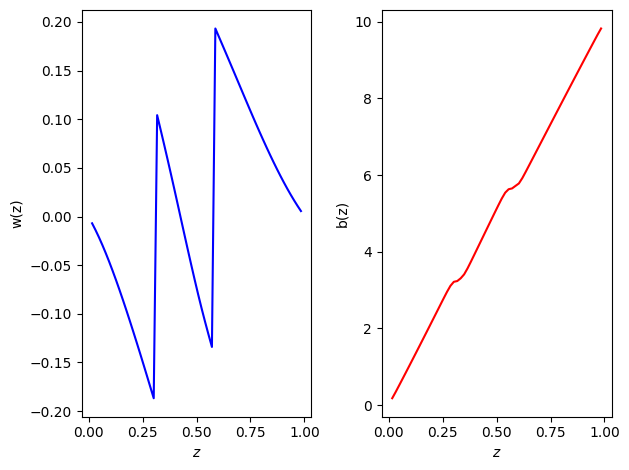

Iteration i = 70, Residual error r_i = 8.152577e-04 



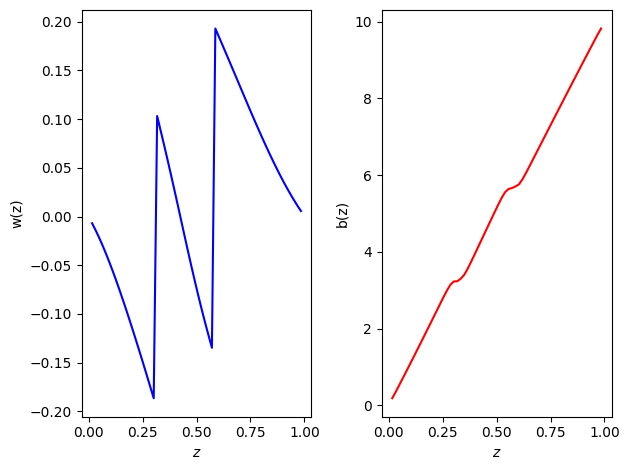

Iteration i = 80, Residual error r_i = 8.276370e-04 



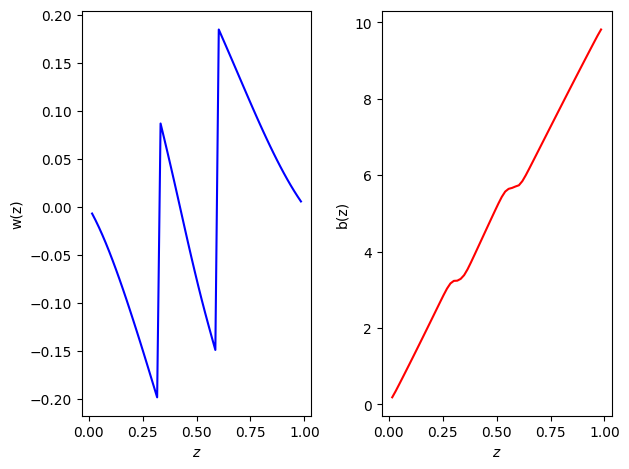

Iteration i = 90, Residual error r_i = 9.084974e-04 



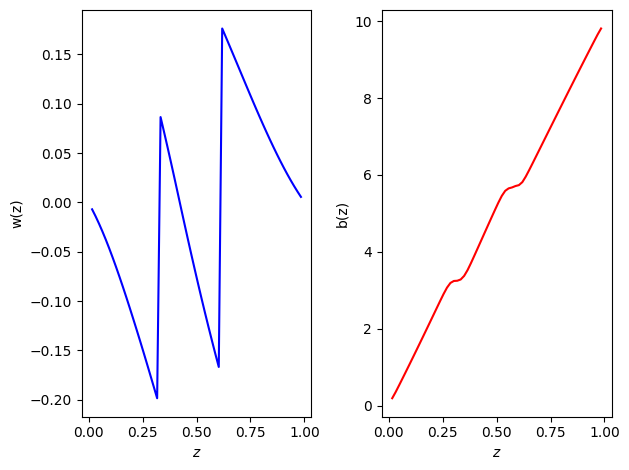

Iteration i = 100, Residual error r_i = 8.501273e-04 



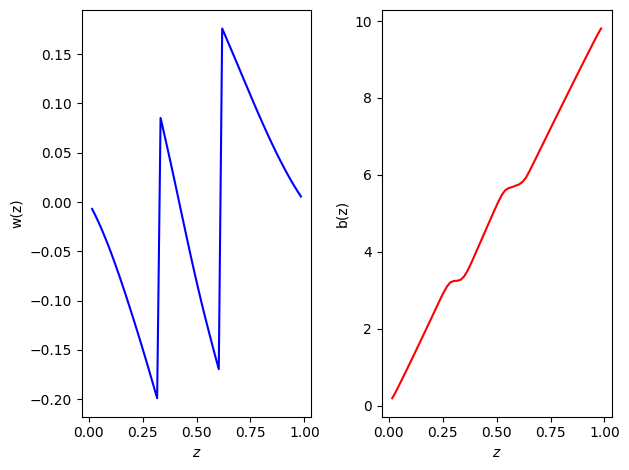

Iteration i = 110, Residual error r_i = 8.198021e-04 



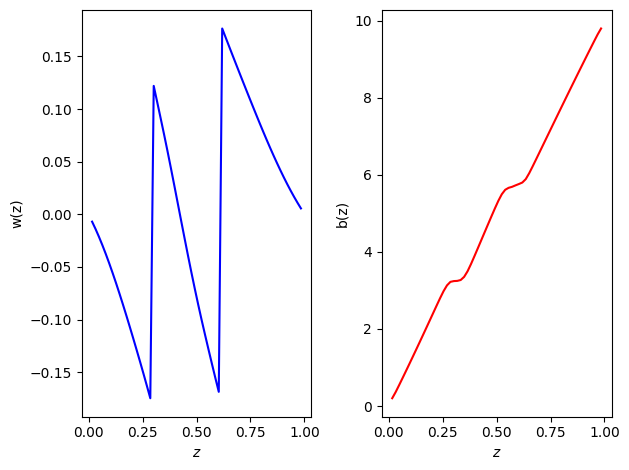

Iteration i = 120, Residual error r_i = 7.772002e-04 



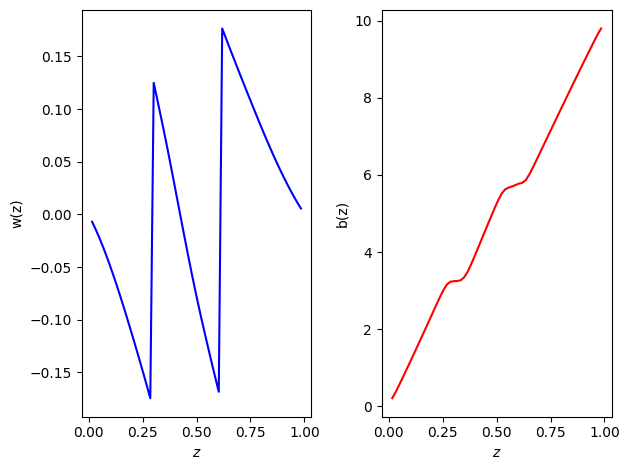

Iteration i = 130, Residual error r_i = 1.259311e-03 



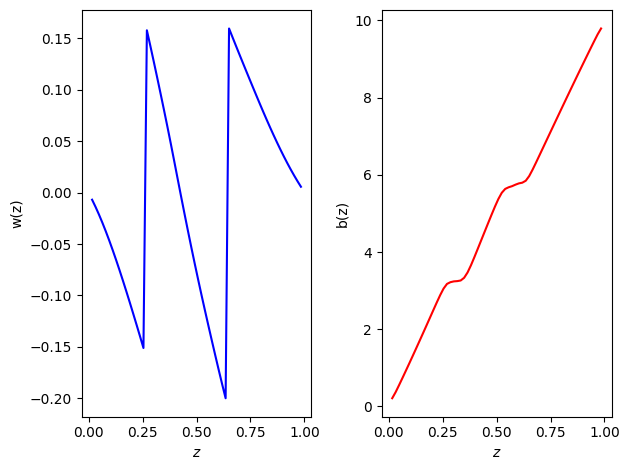

Iteration i = 140, Residual error r_i = 9.576200e-04 



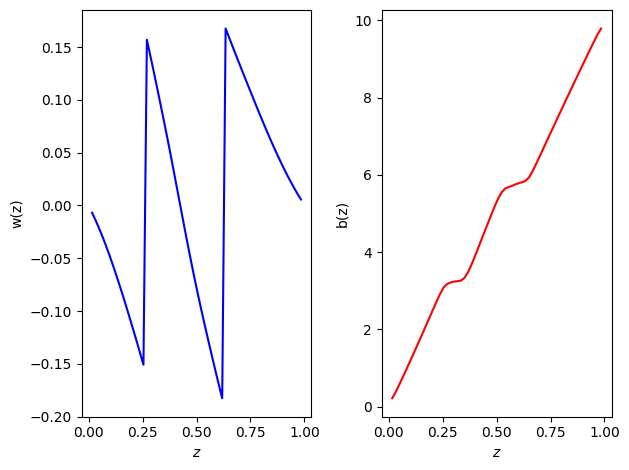

Iteration i = 150, Residual error r_i = 8.955508e-04 



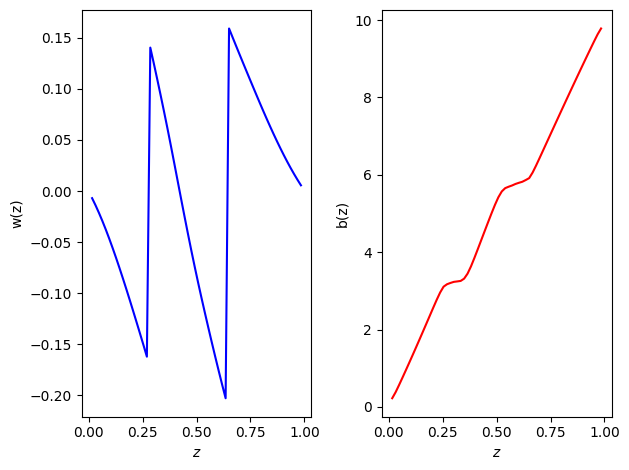

Iteration i = 160, Residual error r_i = 8.281812e-04 



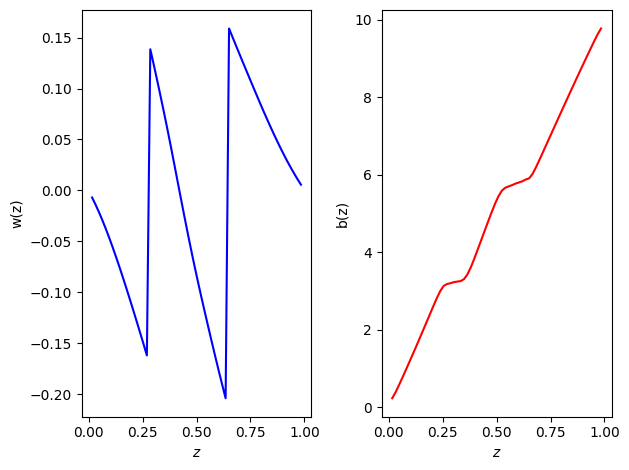

Iteration i = 170, Residual error r_i = 7.614100e-04 



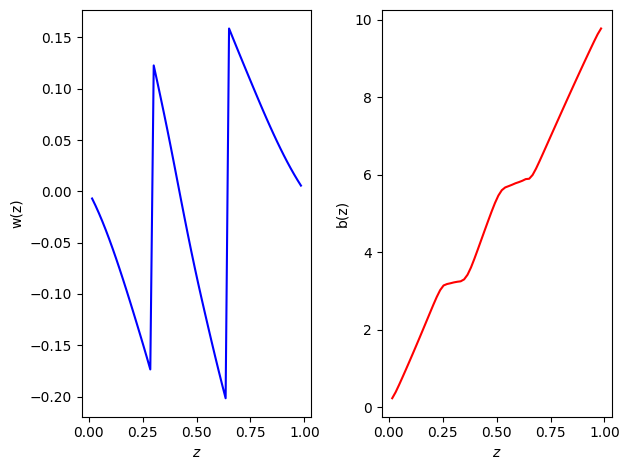

Iteration i = 180, Residual error r_i = 8.387971e-04 



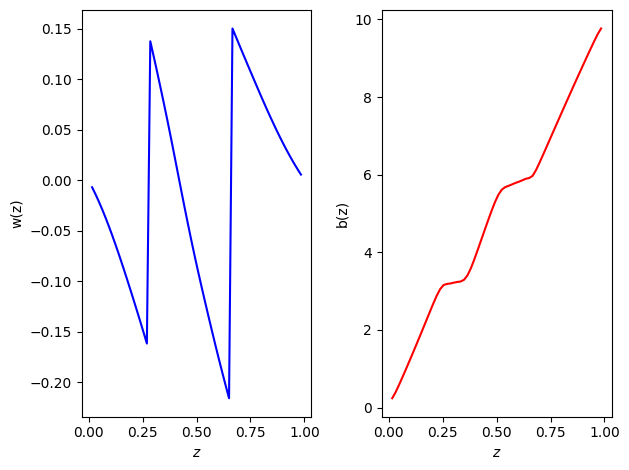

Iteration i = 190, Residual error r_i = 1.055132e-03 



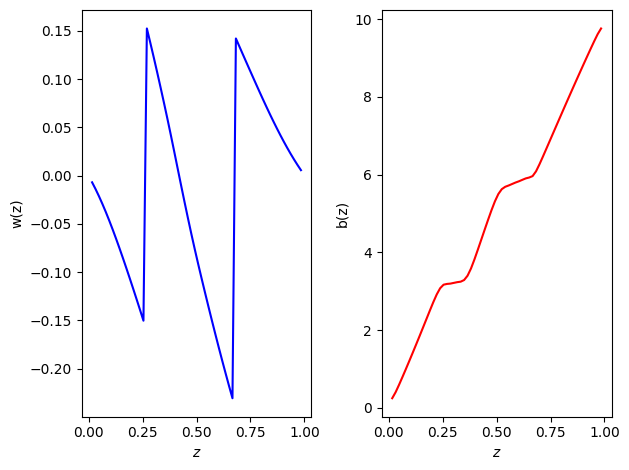

Iteration i = 200, Residual error r_i = 9.326394e-04 



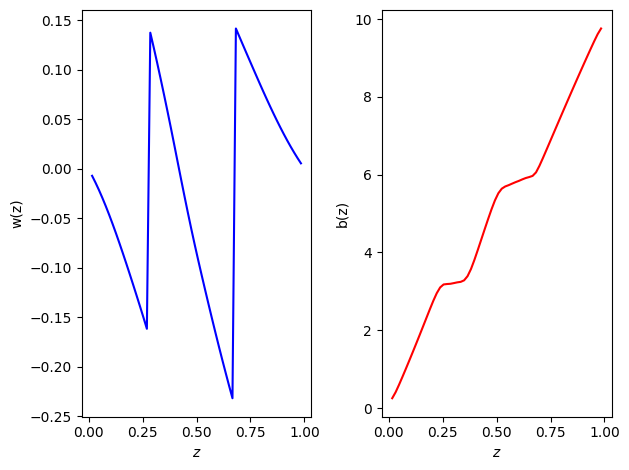

Iteration i = 210, Residual error r_i = 8.501292e-04 



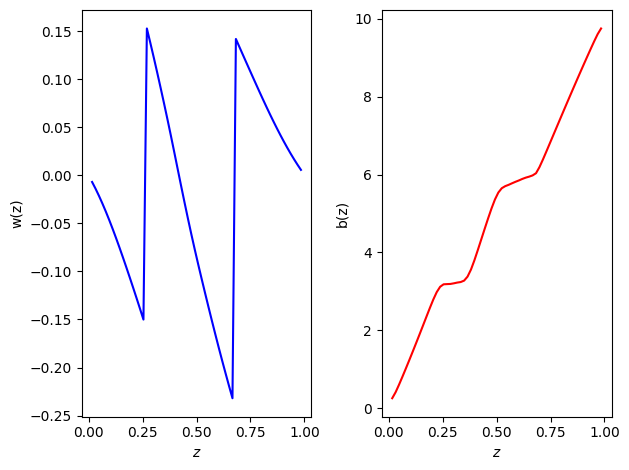

Iteration i = 220, Residual error r_i = 7.028957e-04 



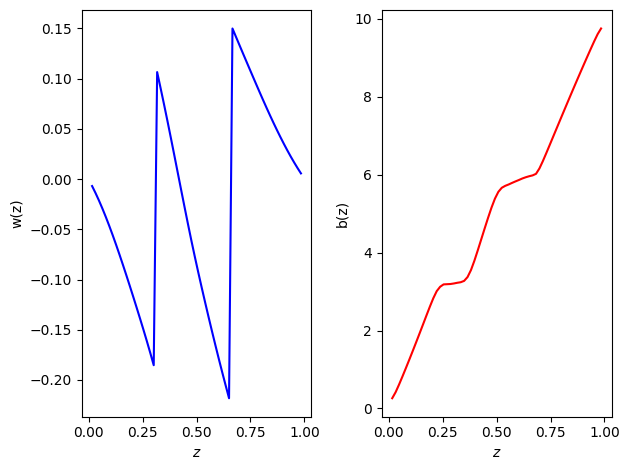

Iteration i = 230, Residual error r_i = 7.292160e-04 



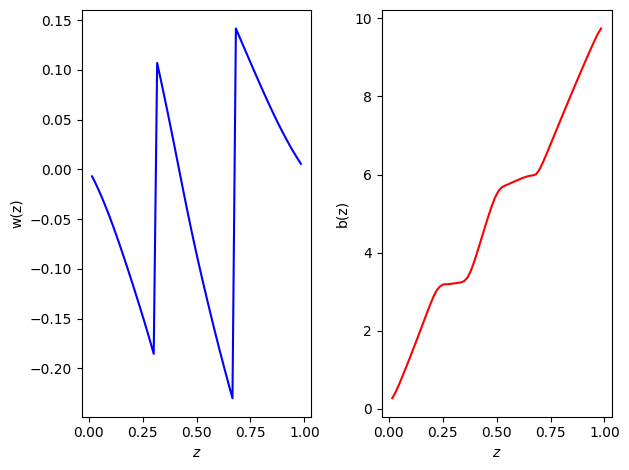

Iteration i = 240, Residual error r_i = 6.730330e-04 



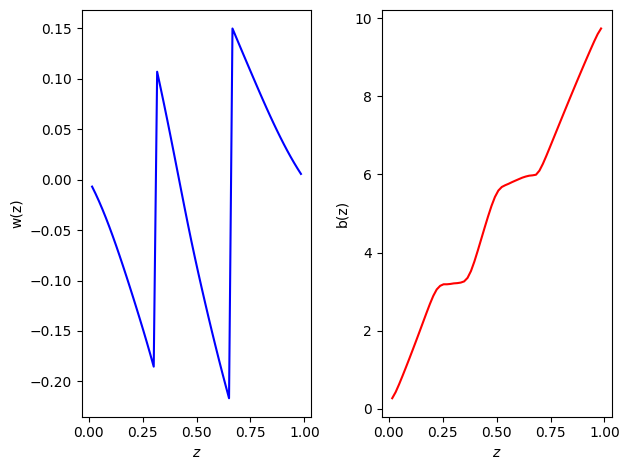

Iteration i = 250, Residual error r_i = 6.755501e-04 



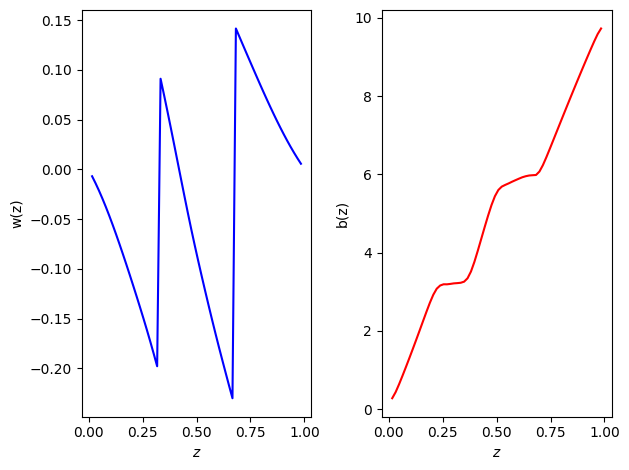

Iteration i = 260, Residual error r_i = 6.716944e-04 



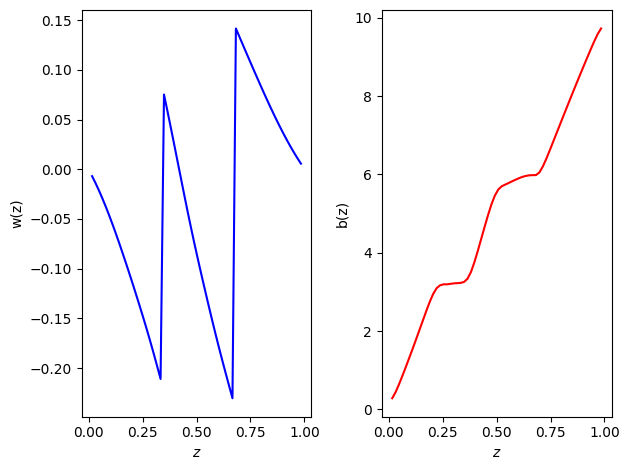

Iteration i = 270, Residual error r_i = 7.454502e-04 



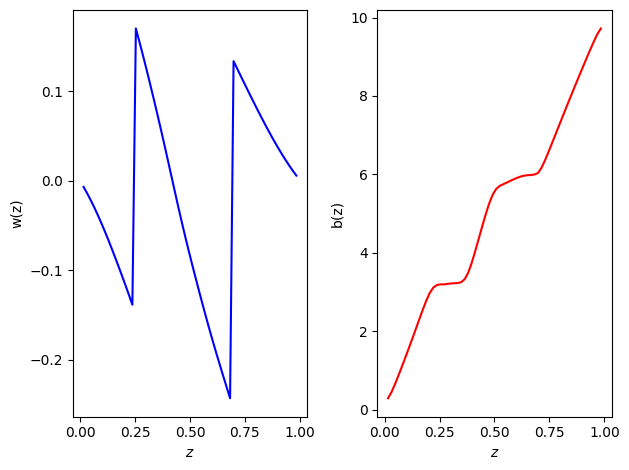

Iteration i = 280, Residual error r_i = 6.972953e-04 



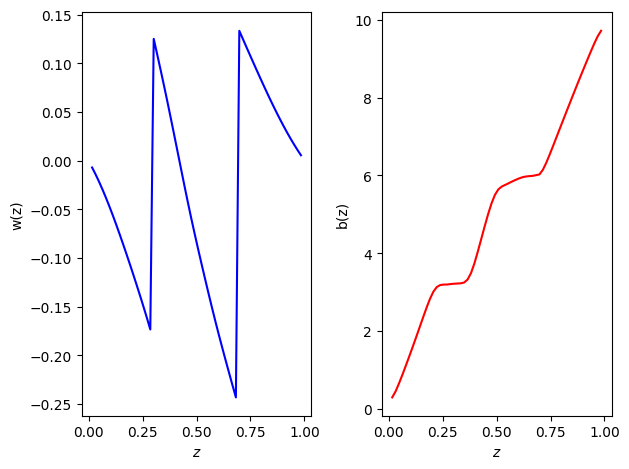

Iteration i = 290, Residual error r_i = 6.704717e-04 



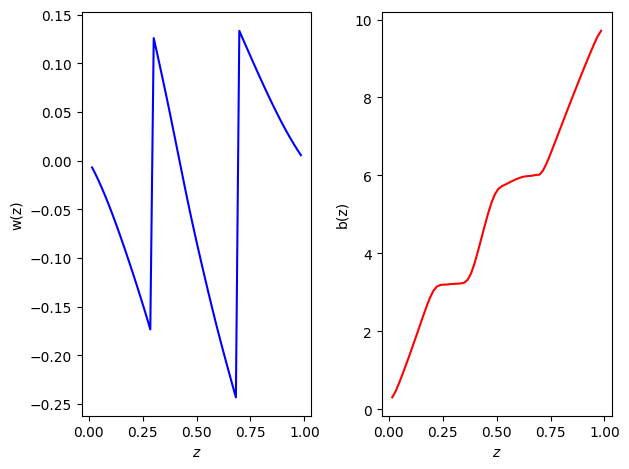

Iteration i = 300, Residual error r_i = 6.515267e-04 



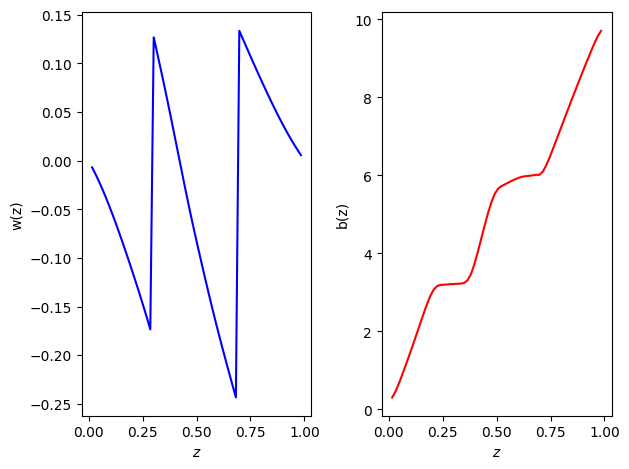

Iteration i = 310, Residual error r_i = 6.388012e-04 



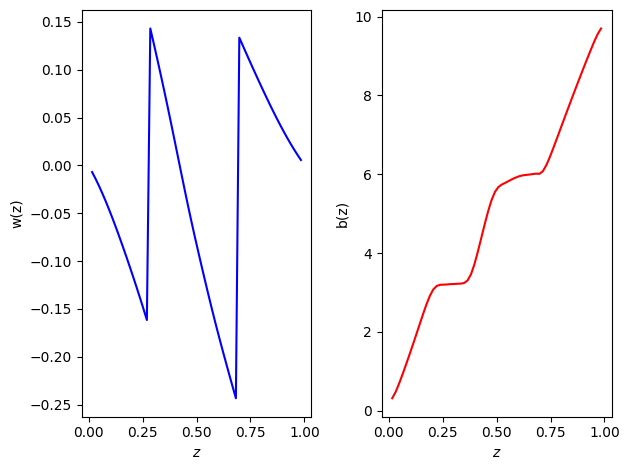

Iteration i = 320, Residual error r_i = 7.019559e-04 



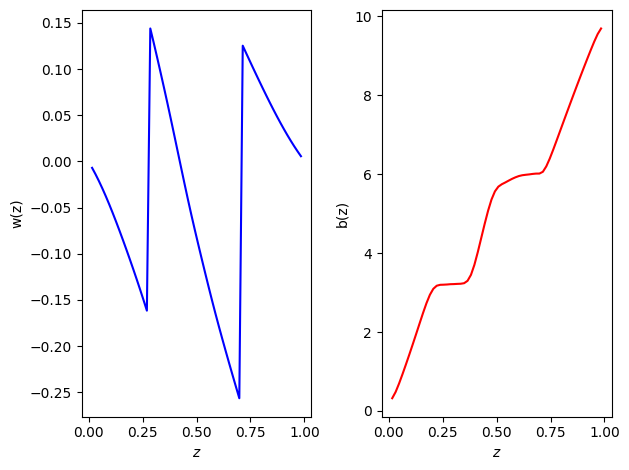

Iteration i = 330, Residual error r_i = 6.683488e-04 



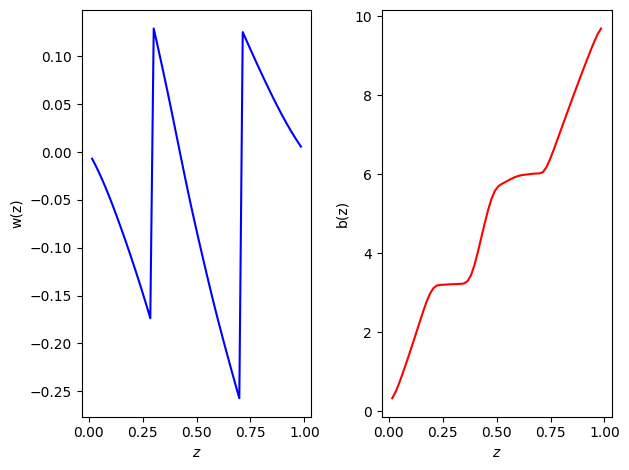

Iteration i = 340, Residual error r_i = 6.472674e-04 



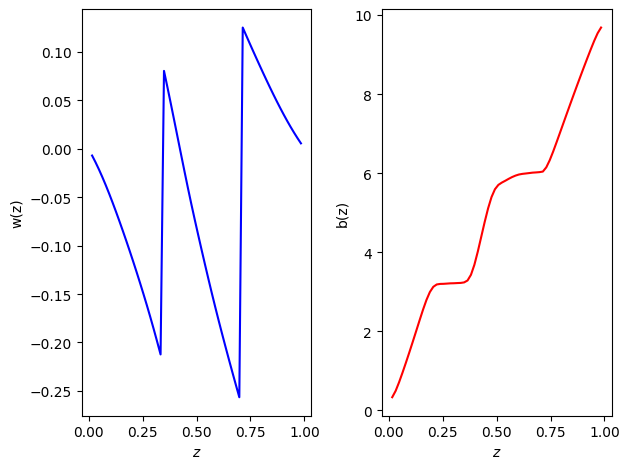

Iteration i = 350, Residual error r_i = 7.034720e-04 



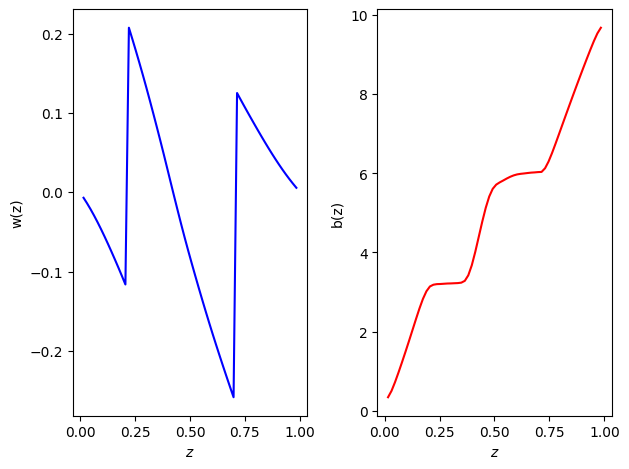

Iteration i = 360, Residual error r_i = 8.047643e-04 



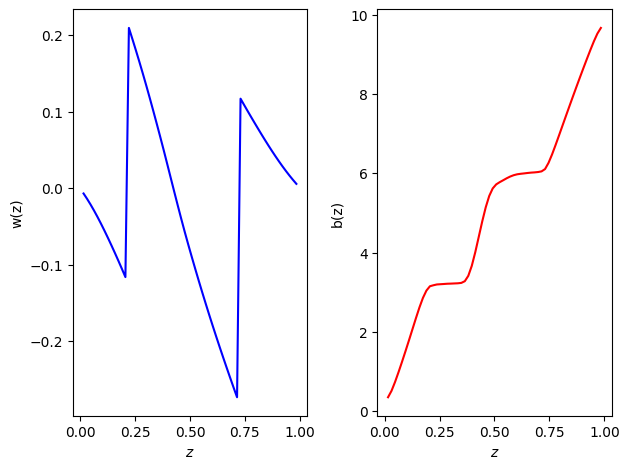

Iteration i = 370, Residual error r_i = 7.177586e-04 



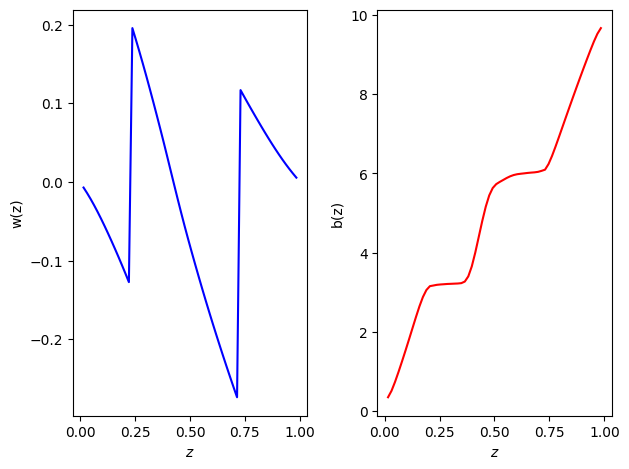

Iteration i = 380, Residual error r_i = 6.928943e-04 



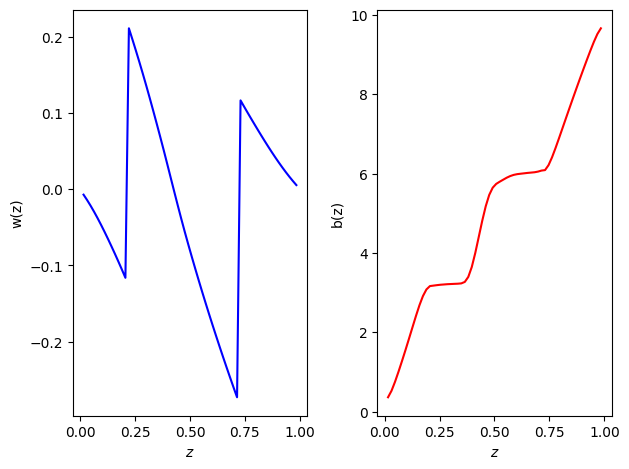

Iteration i = 390, Residual error r_i = 6.563834e-04 



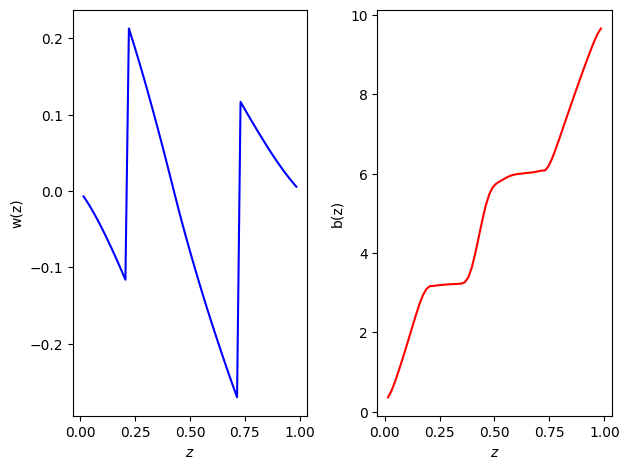

Iteration i = 400, Residual error r_i = 7.051991e-04 



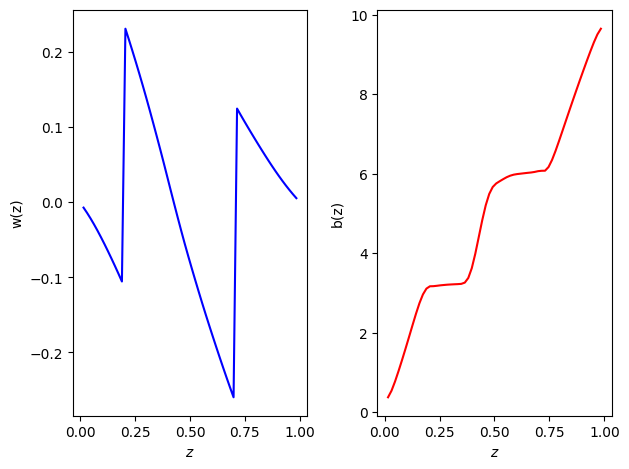

Iteration i = 410, Residual error r_i = 6.714625e-04 



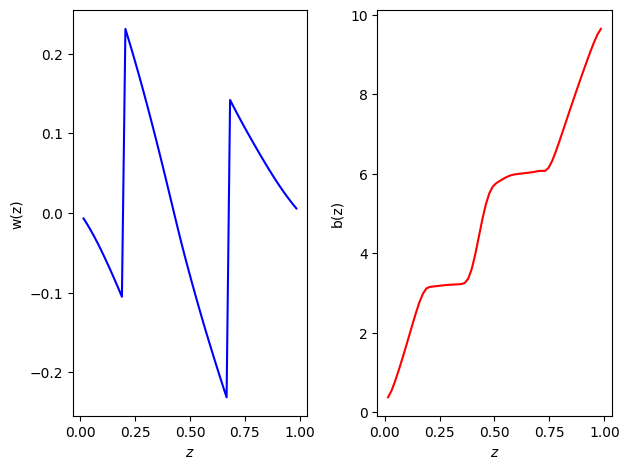

Iteration i = 420, Residual error r_i = 6.532513e-04 



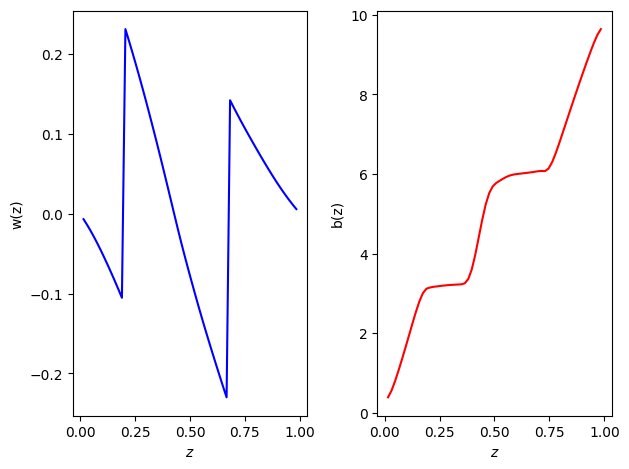

Iteration i = 430, Residual error r_i = 8.735198e-04 



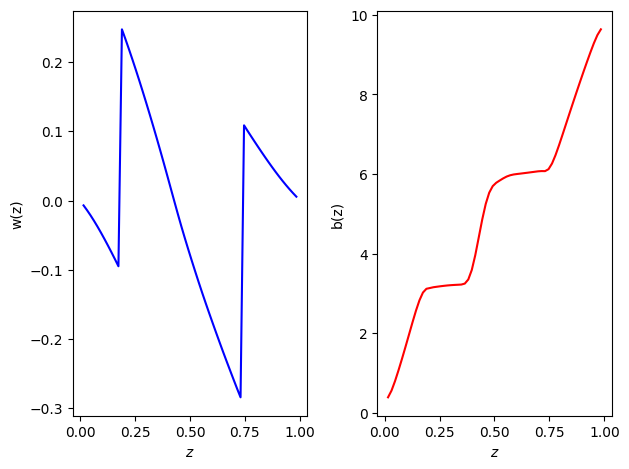

Iteration i = 440, Residual error r_i = 6.670703e-04 



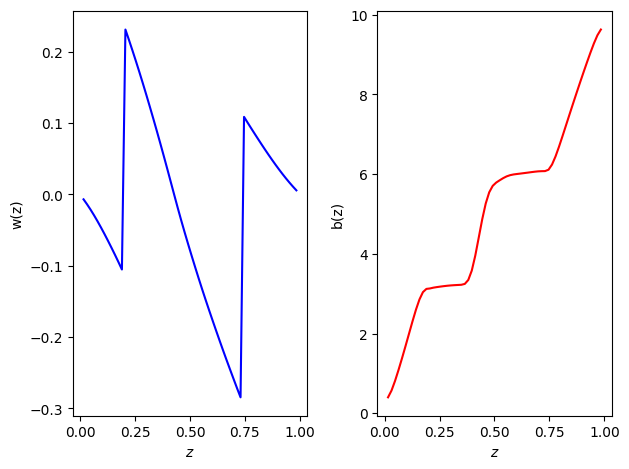

Iteration i = 450, Residual error r_i = 6.185845e-04 



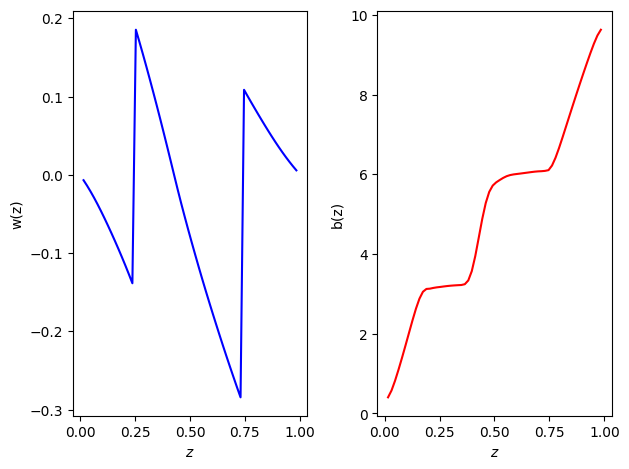

Iteration i = 460, Residual error r_i = 5.802439e-04 



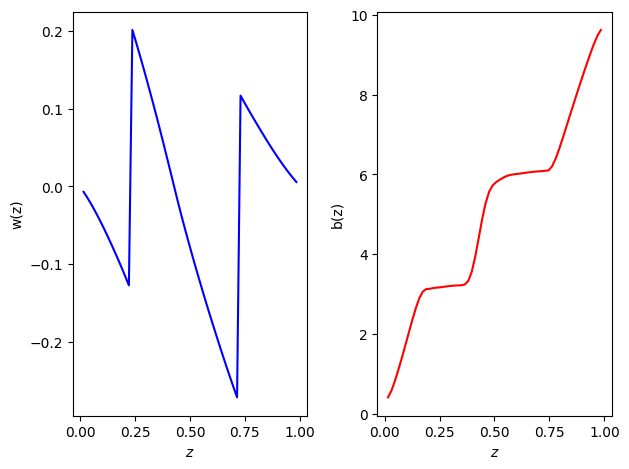

Iteration i = 470, Residual error r_i = 5.696372e-04 



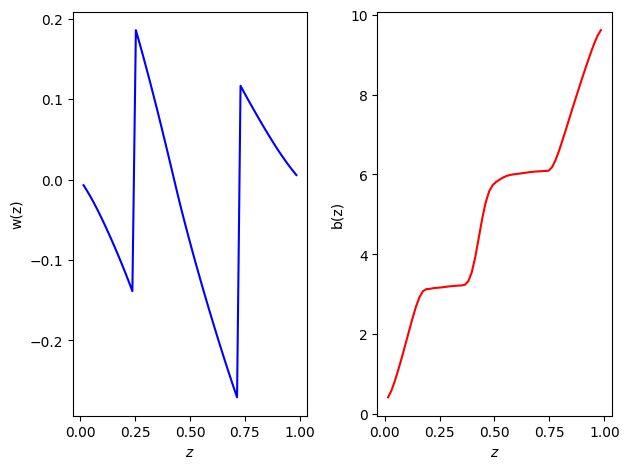

Iteration i = 480, Residual error r_i = 5.615432e-04 



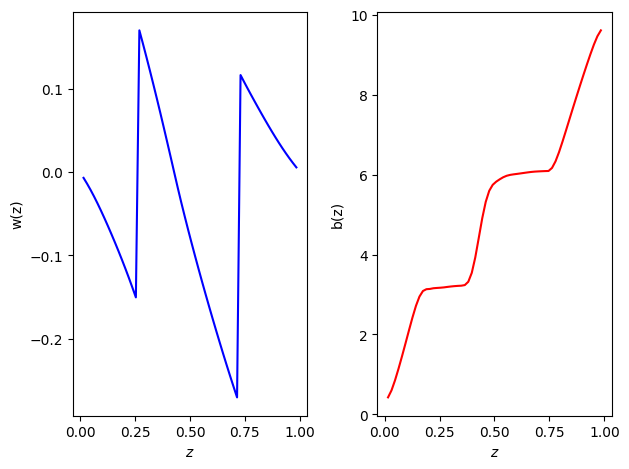

Iteration i = 490, Residual error r_i = 5.572891e-04 



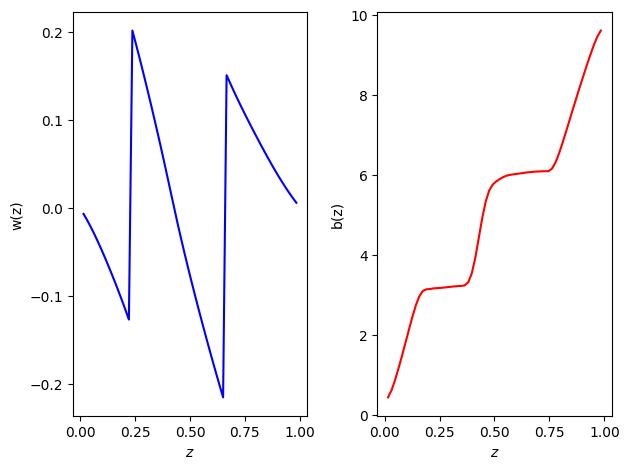

Iteration i = 500, Residual error r_i = 5.494980e-04 



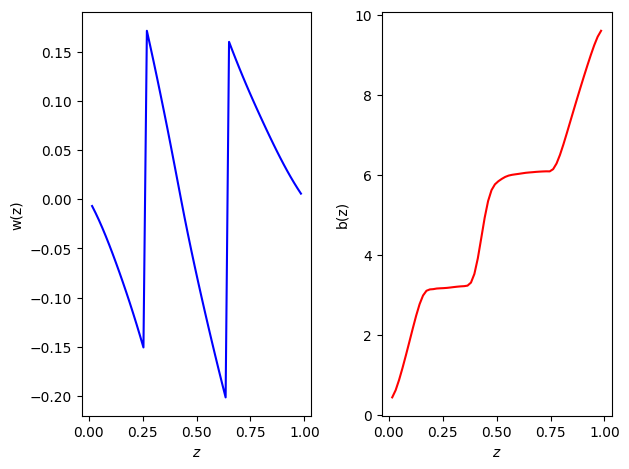

Iteration i = 510, Residual error r_i = 6.131987e-04 



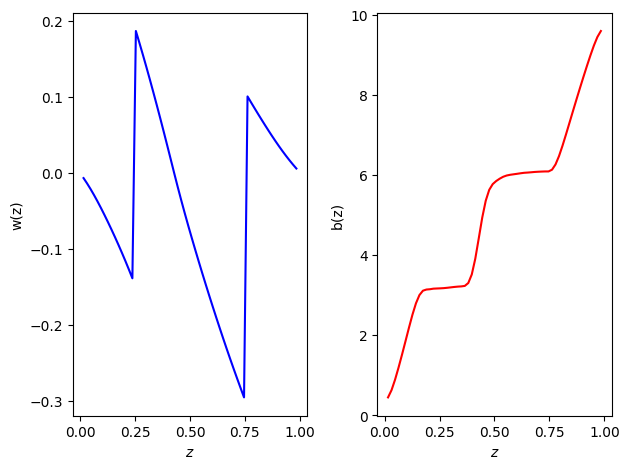

Iteration i = 520, Residual error r_i = 5.857931e-04 



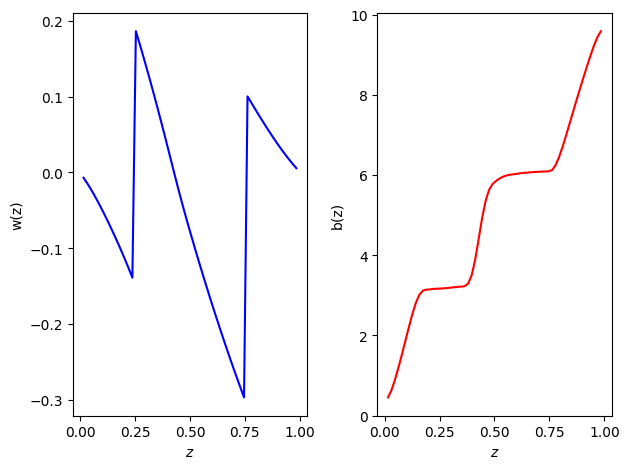

Iteration i = 530, Residual error r_i = 5.667471e-04 



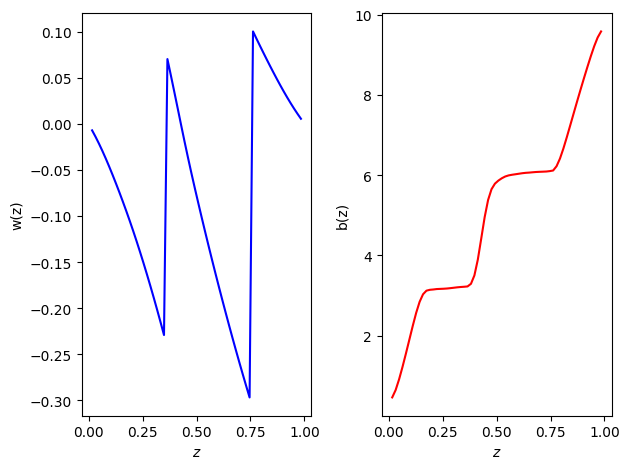

Iteration i = 540, Residual error r_i = 5.256547e-04 



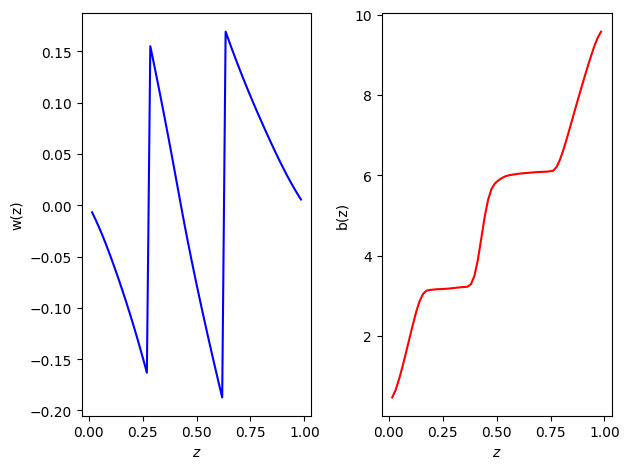

Iteration i = 550, Residual error r_i = 5.380123e-04 



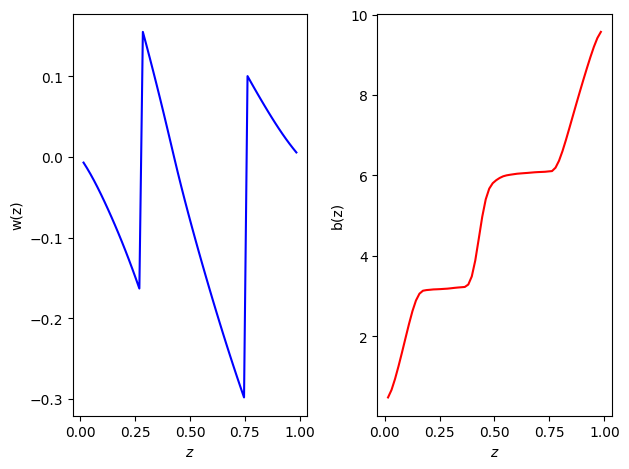

Iteration i = 560, Residual error r_i = 5.126873e-04 



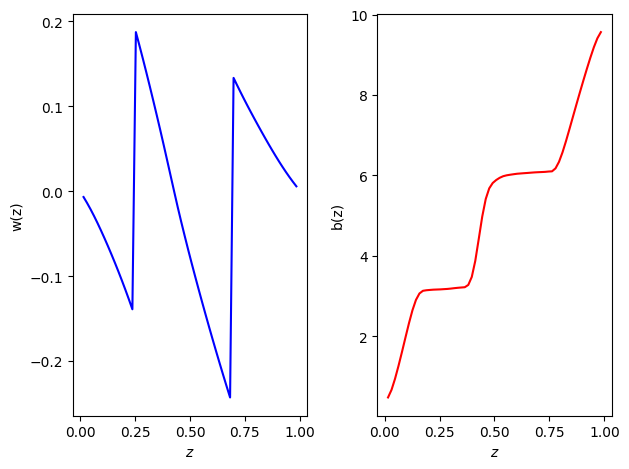

Iteration i = 570, Residual error r_i = 6.518585e-04 



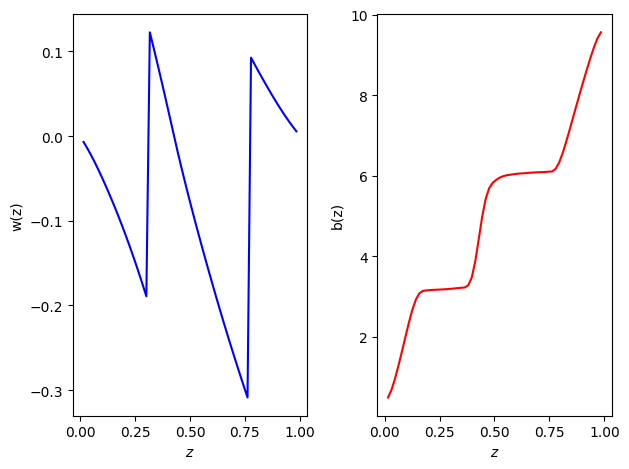

Iteration i = 580, Residual error r_i = 5.158771e-04 



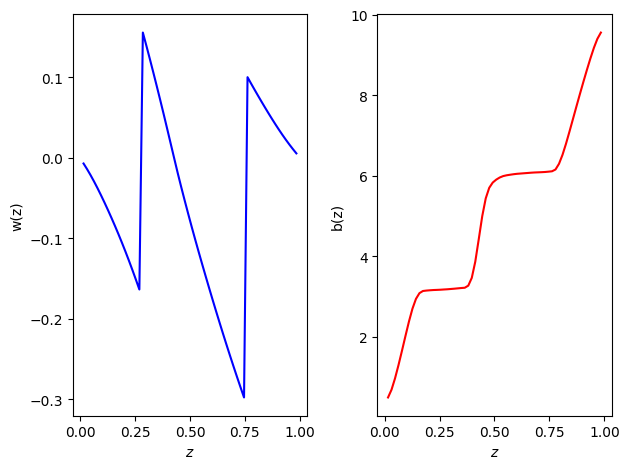

Iteration i = 590, Residual error r_i = 6.103745e-04 



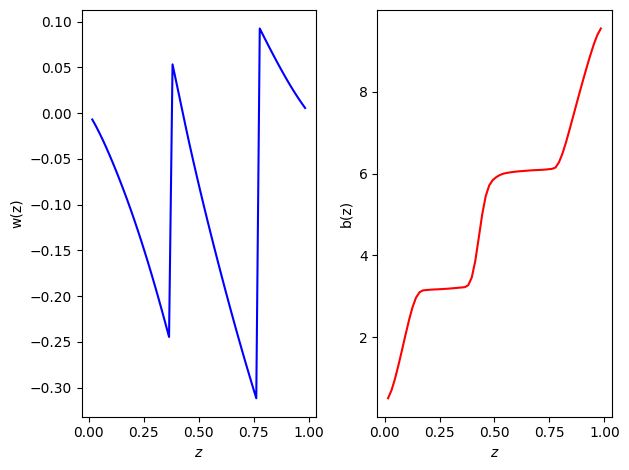

Iteration i = 600, Residual error r_i = 5.476200e-04 



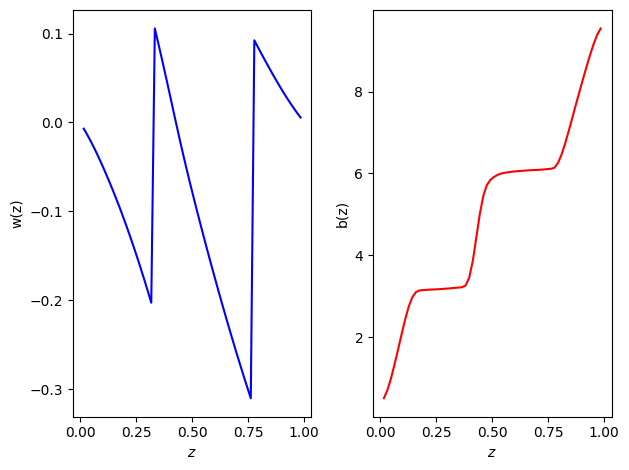

Iteration i = 610, Residual error r_i = 4.982410e-04 



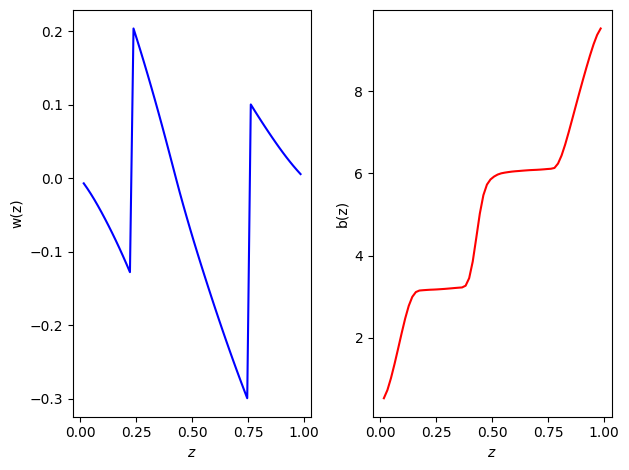

Iteration i = 620, Residual error r_i = 4.868269e-04 



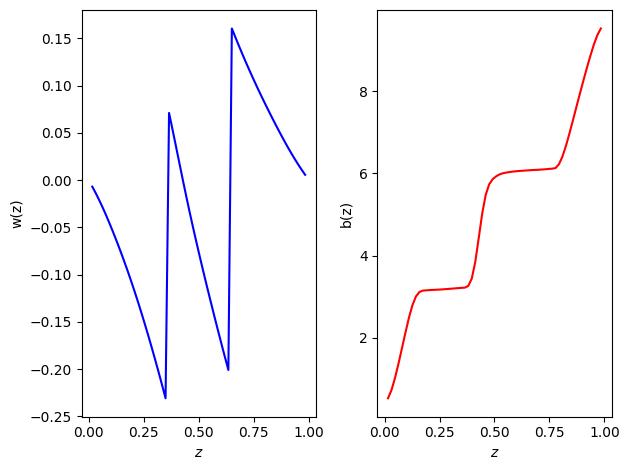

Iteration i = 630, Residual error r_i = 5.068981e-04 



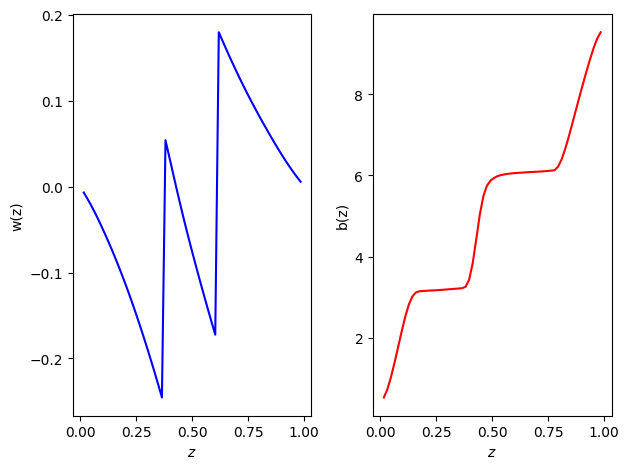

Iteration i = 640, Residual error r_i = 4.796312e-04 



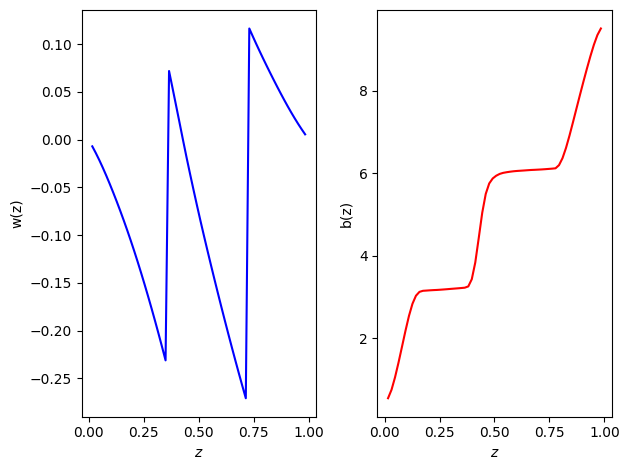

Iteration i = 650, Residual error r_i = 4.720894e-04 



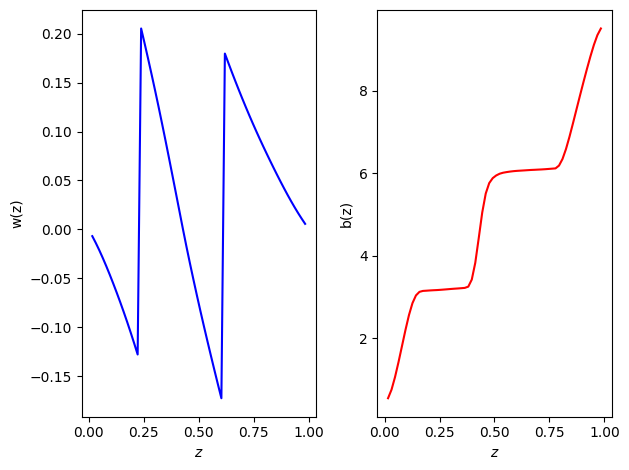

Iteration i = 660, Residual error r_i = 4.670164e-04 



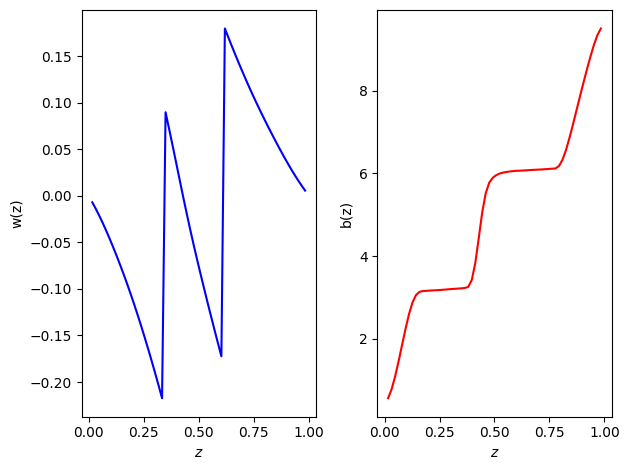

Iteration i = 670, Residual error r_i = 4.629983e-04 



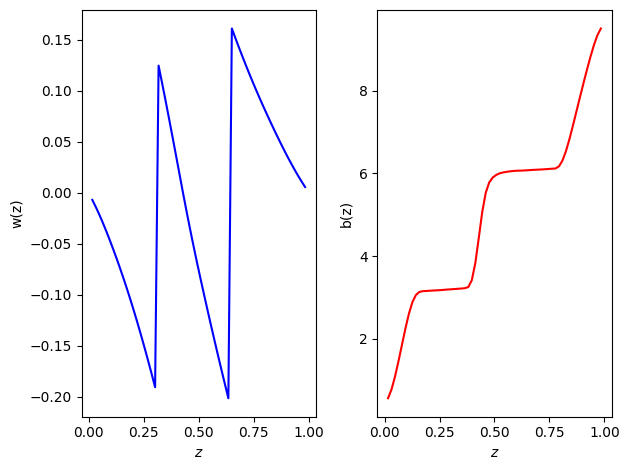

Iteration i = 680, Residual error r_i = 4.574394e-04 



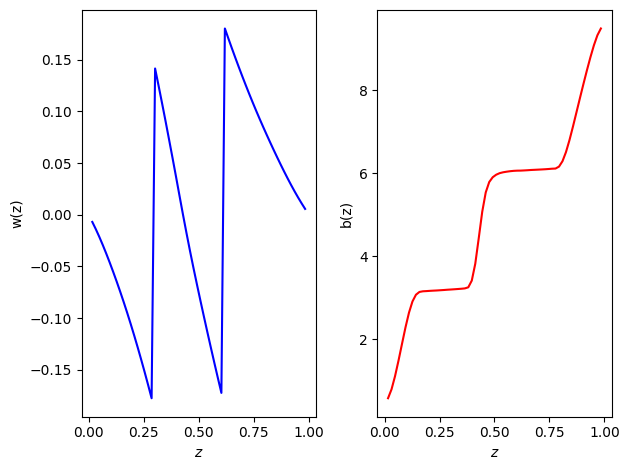

Iteration i = 690, Residual error r_i = 4.670681e-04 



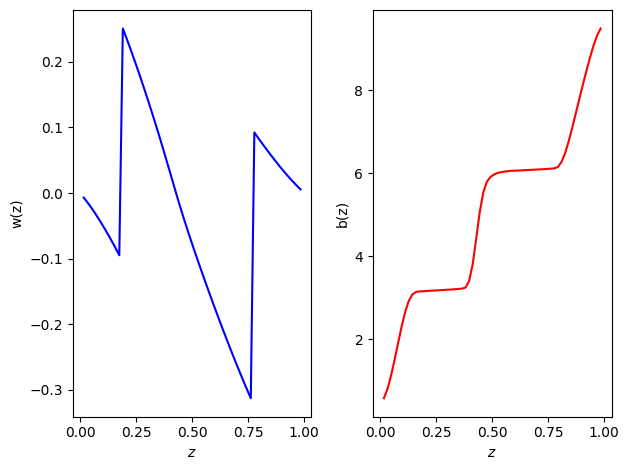

Iteration i = 700, Residual error r_i = 4.689528e-04 



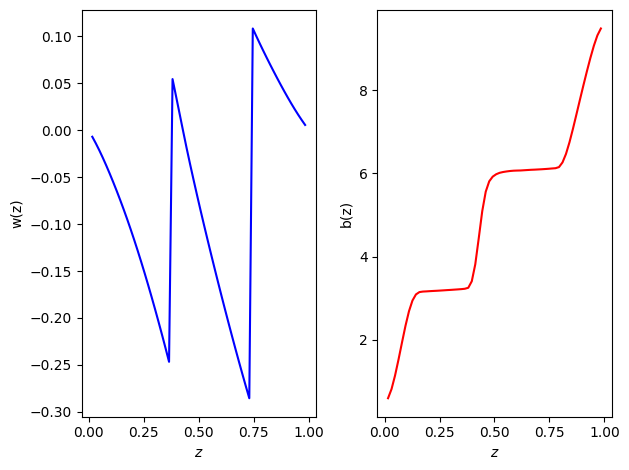

Iteration i = 710, Residual error r_i = 7.983415e-04 



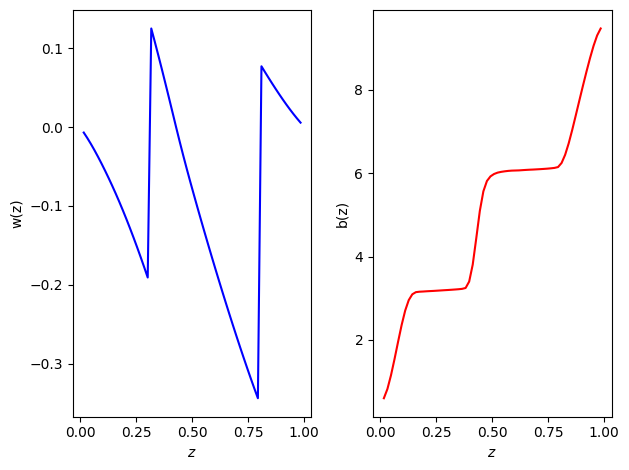

Iteration i = 720, Residual error r_i = 4.881748e-04 



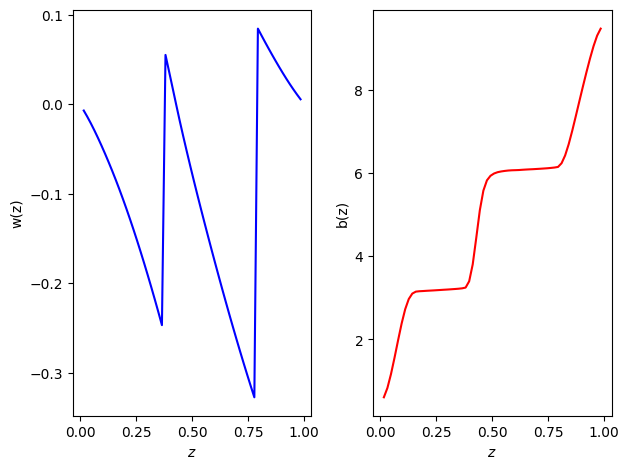

Iteration i = 730, Residual error r_i = 4.693134e-04 



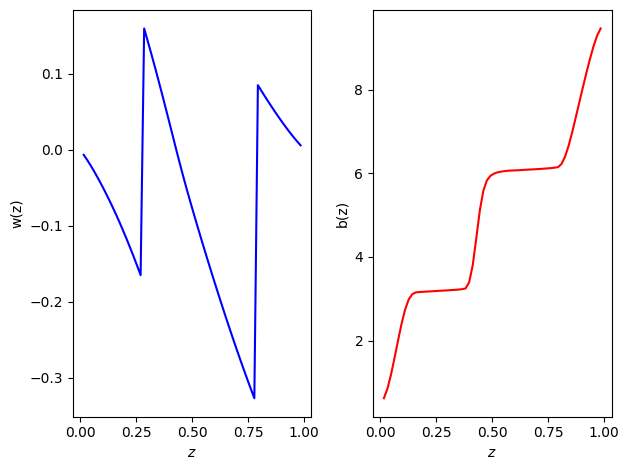

Iteration i = 740, Residual error r_i = 4.474153e-04 



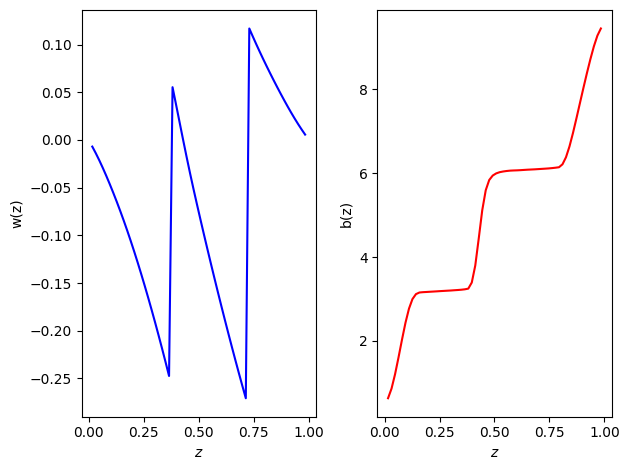

Iteration i = 750, Residual error r_i = 4.609566e-04 



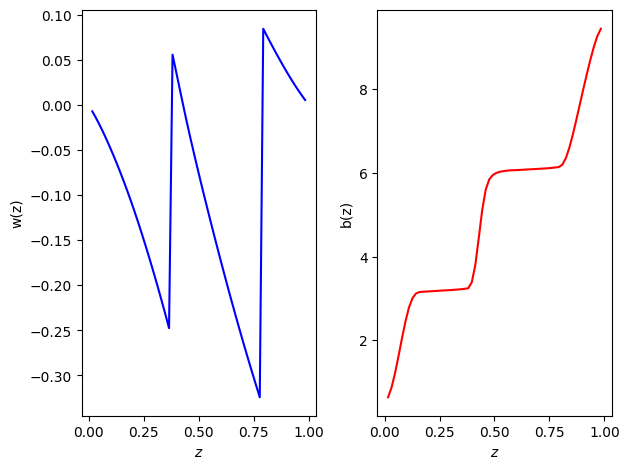

Iteration i = 760, Residual error r_i = 5.725207e-04 



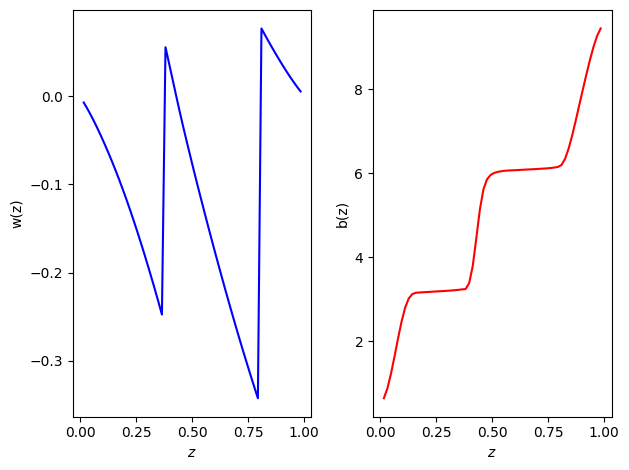

Iteration i = 770, Residual error r_i = 4.293646e-04 



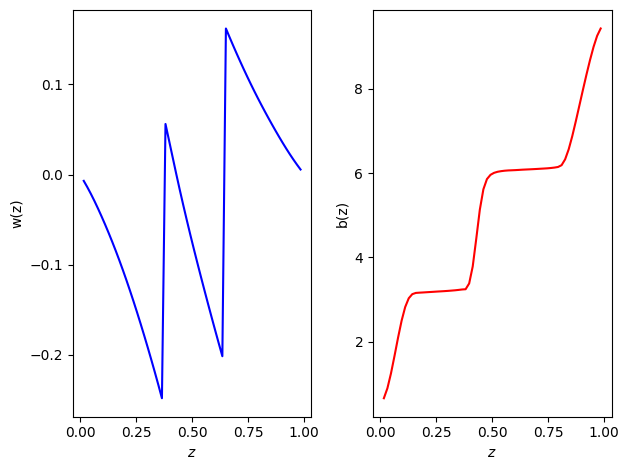

Iteration i = 780, Residual error r_i = 4.237315e-04 



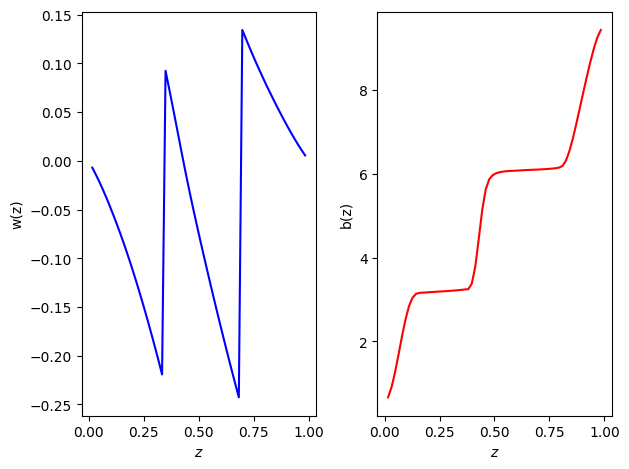

Iteration i = 790, Residual error r_i = 4.195155e-04 



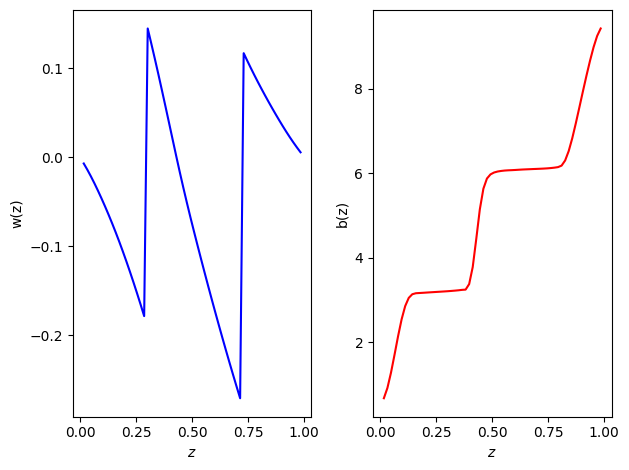

Iteration i = 800, Residual error r_i = 4.327280e-04 



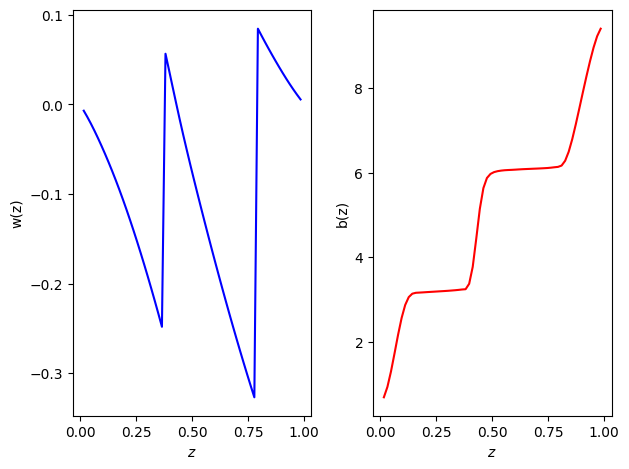

Iteration i = 810, Residual error r_i = 5.515108e-03 



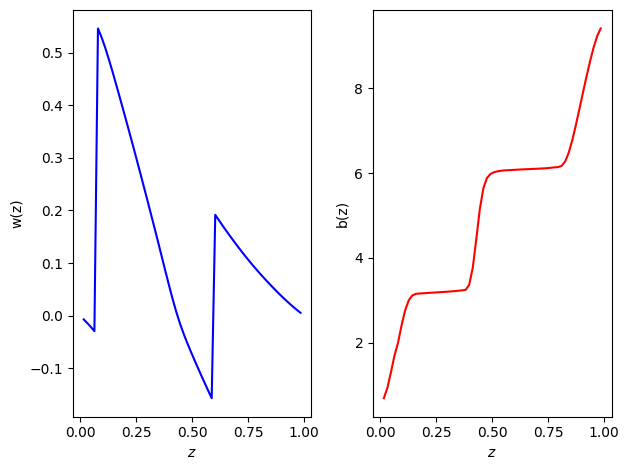

<ipython-input-125-014008445866>:5: RuntimeWarning: invalid value encountered in scalar power
  α    = -(3/8)*δ + (1/4)*( (F * Q**2)/M**2.5 )
<ipython-input-125-014008445866>:8: RuntimeWarning: invalid value encountered in scalar power
  dQdz = 2*α*np.sqrt(np.pi)*(M**0.5)


Iteration i = 820, Residual error r_i = 4.627337e-03 



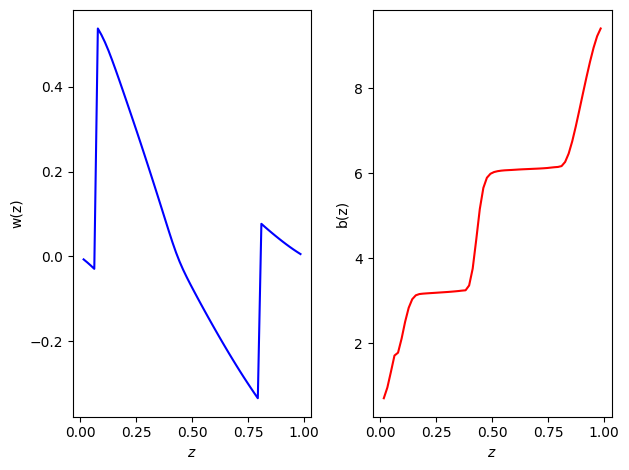

Iteration i = 830, Residual error r_i = 4.225949e-03 



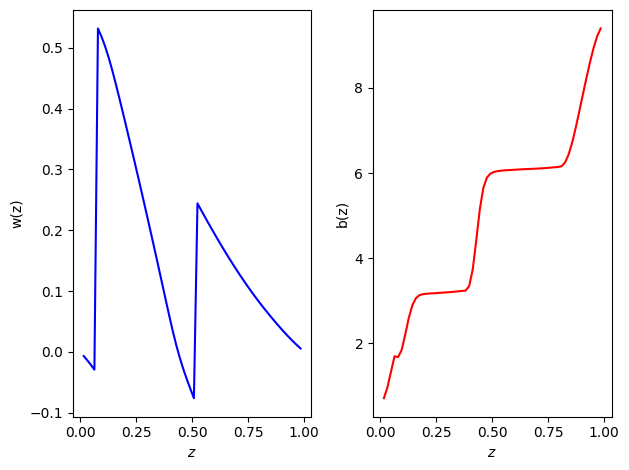

Iteration i = 840, Residual error r_i = 4.126719e-03 



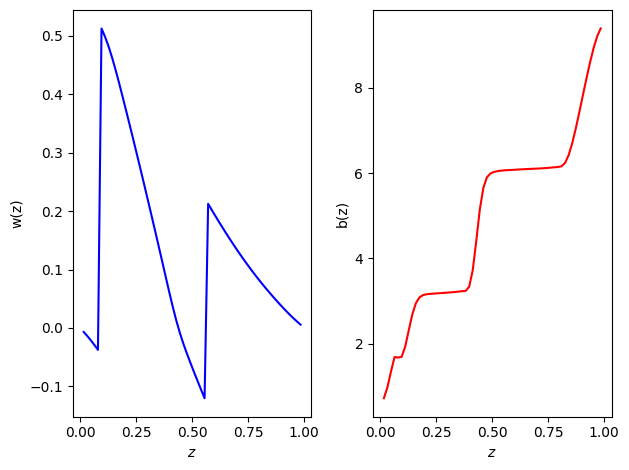

Iteration i = 850, Residual error r_i = 4.032110e-03 



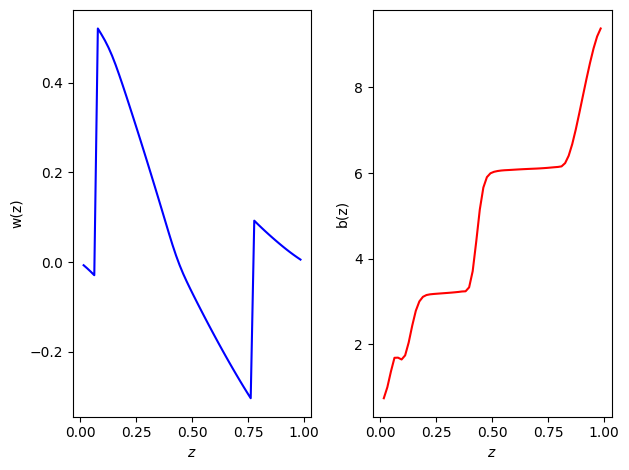

Iteration i = 860, Residual error r_i = 3.963155e-03 



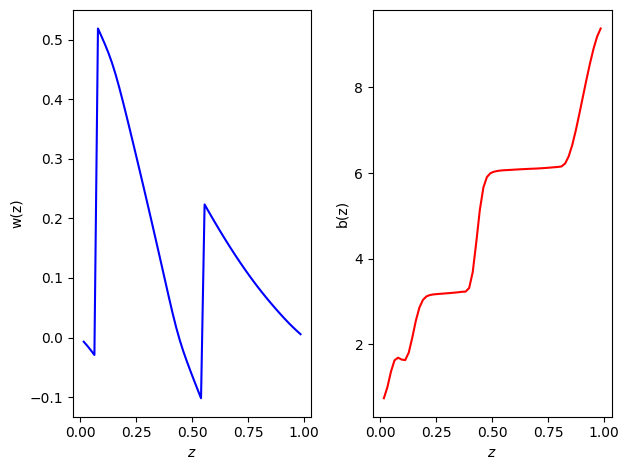

Iteration i = 870, Residual error r_i = 3.914246e-03 



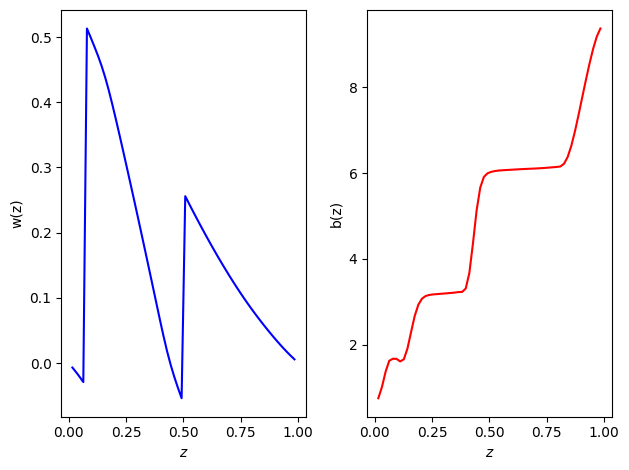

Iteration i = 880, Residual error r_i = 4.266831e-03 



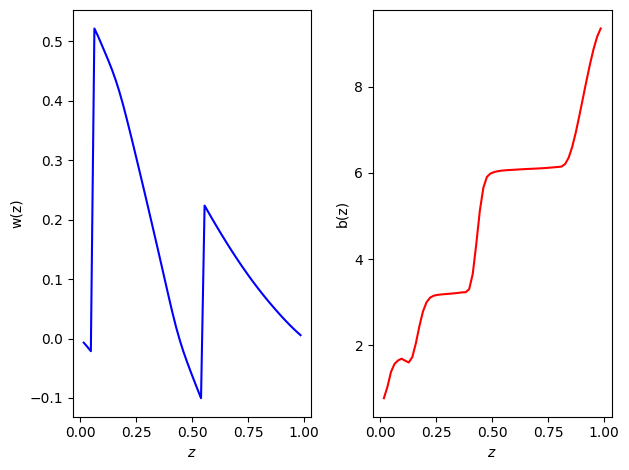

Iteration i = 890, Residual error r_i = 3.850110e-03 



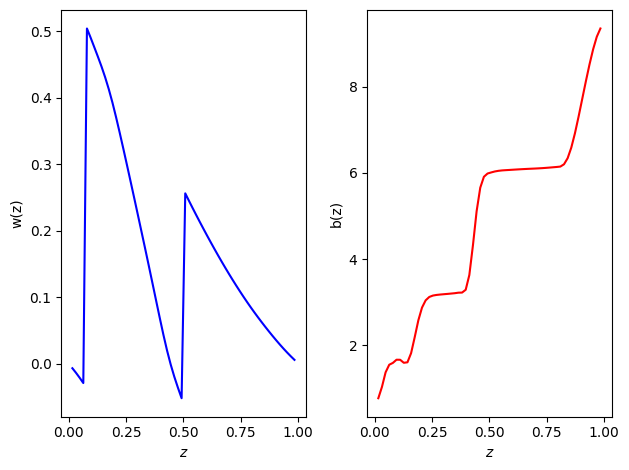

Iteration i = 900, Residual error r_i = 3.745927e-03 



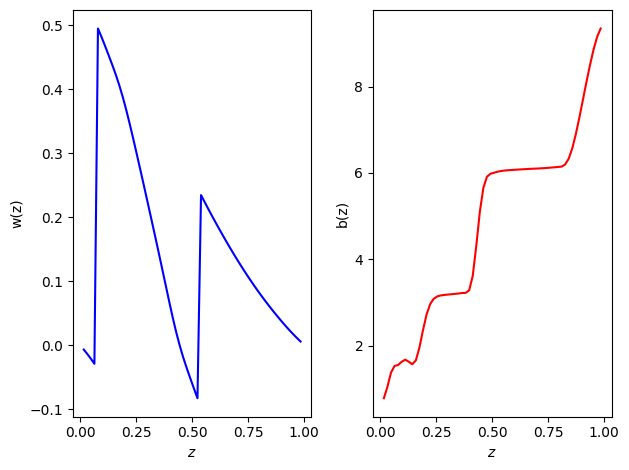

Iteration i = 910, Residual error r_i = 3.639207e-03 



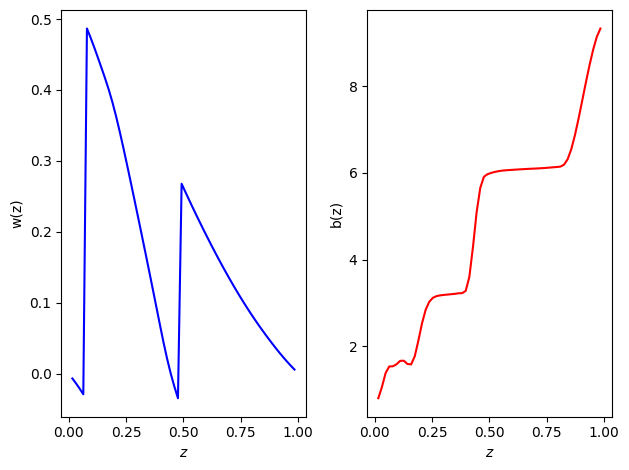

Iteration i = 920, Residual error r_i = 1.288958e-03 



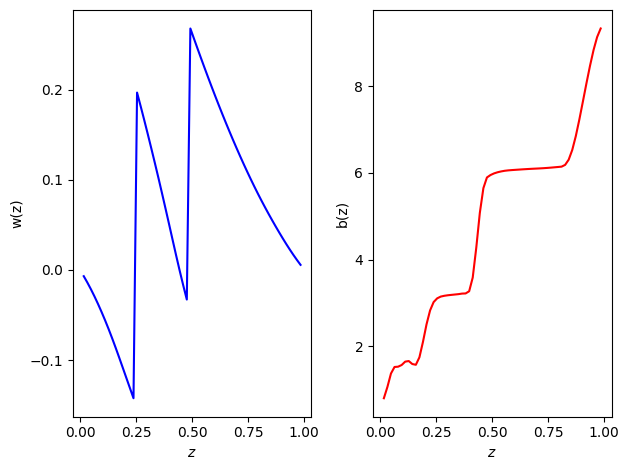

Iteration i = 930, Residual error r_i = 1.071973e-03 



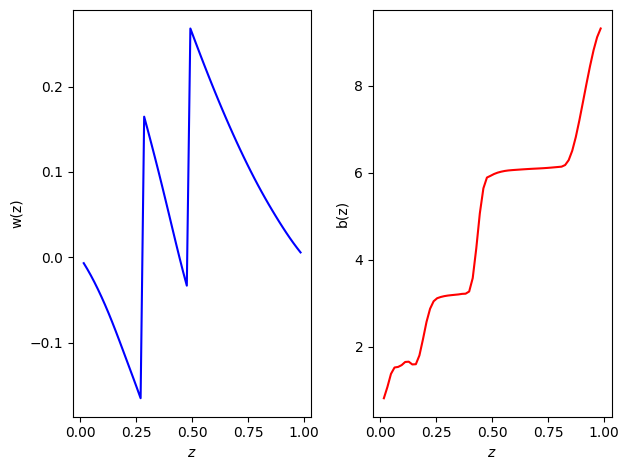

Iteration i = 940, Residual error r_i = 1.043526e-03 



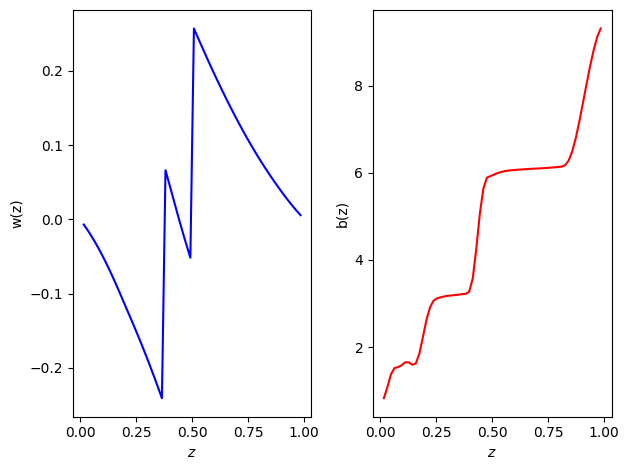

Iteration i = 950, Residual error r_i = 1.021790e-03 



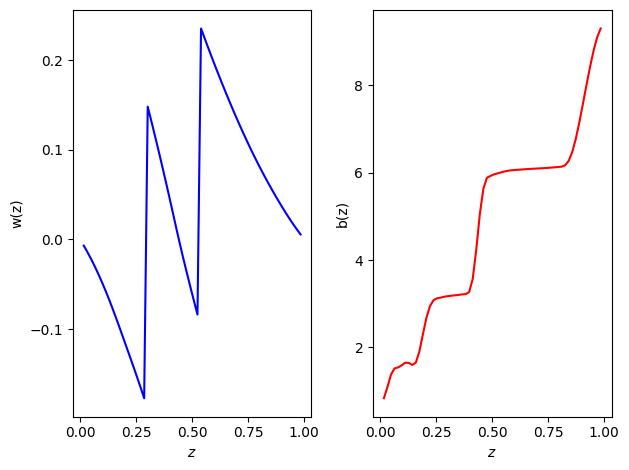

Iteration i = 960, Residual error r_i = 1.056438e-03 



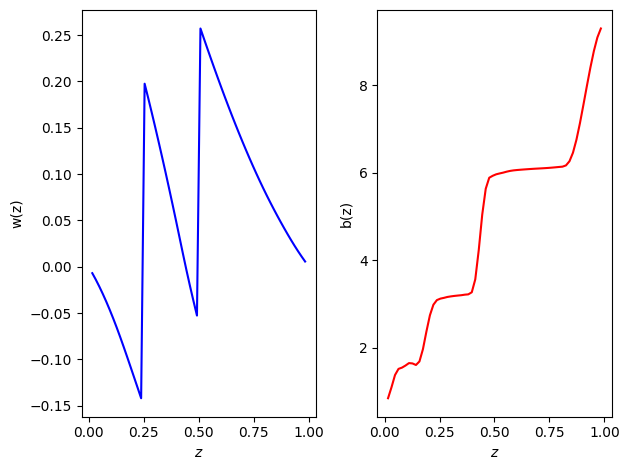

Iteration i = 970, Residual error r_i = 1.018167e-03 



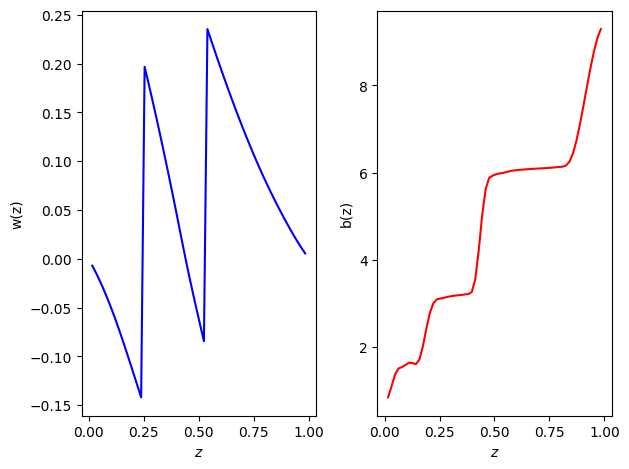

Iteration i = 980, Residual error r_i = 9.672129e-04 



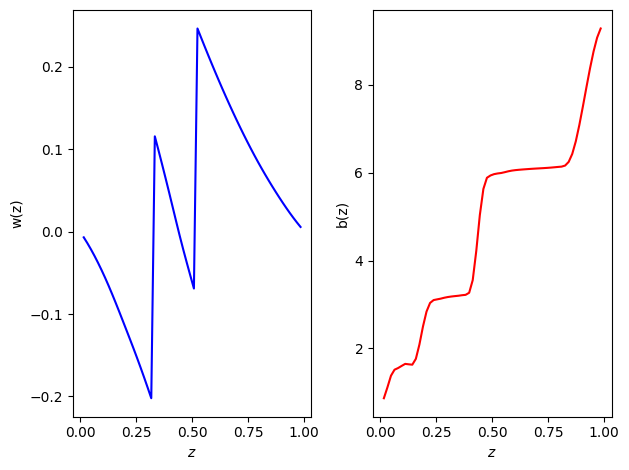

Iteration i = 990, Residual error r_i = 9.703613e-04 



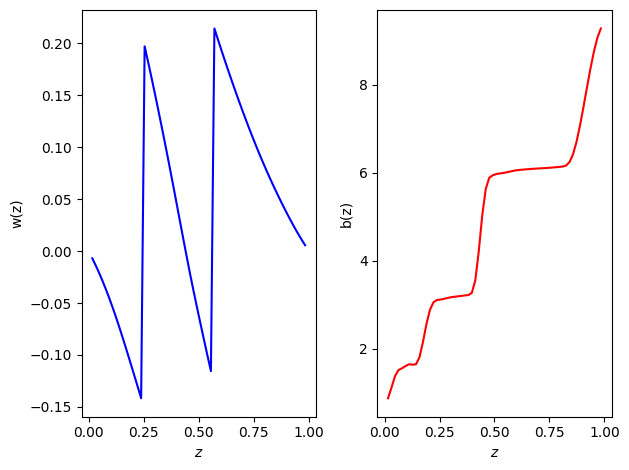

Iteration i = 1000, Residual error r_i = 9.481672e-04 



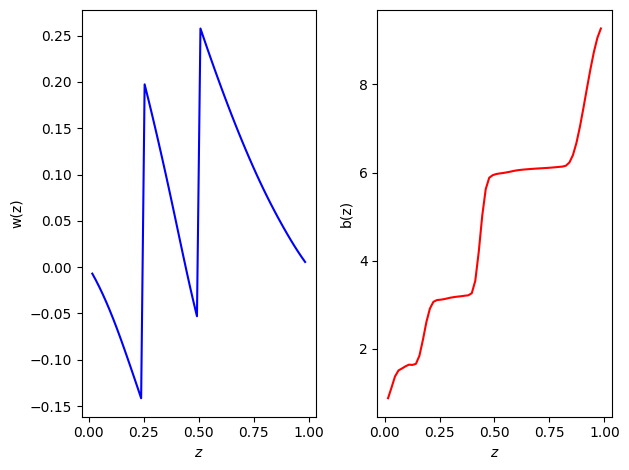

Iteration i = 1010, Residual error r_i = 9.238904e-04 



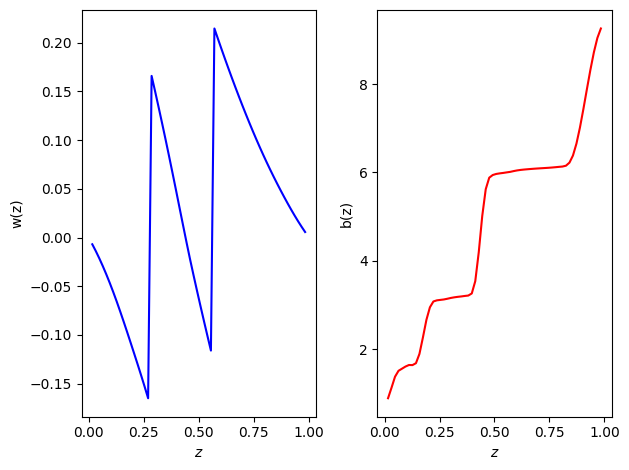

Iteration i = 1020, Residual error r_i = 9.043021e-04 



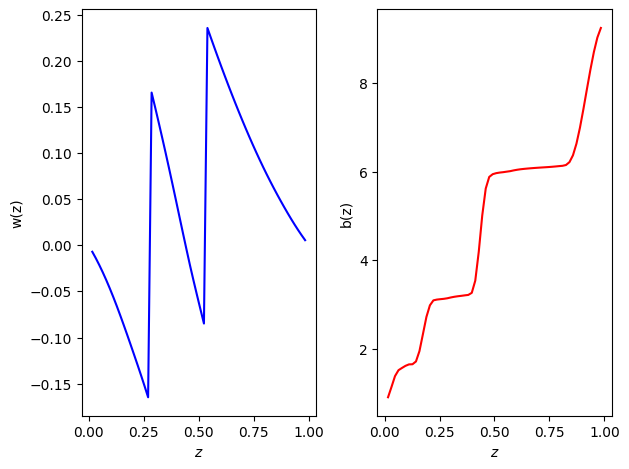

Iteration i = 1030, Residual error r_i = 8.889915e-04 



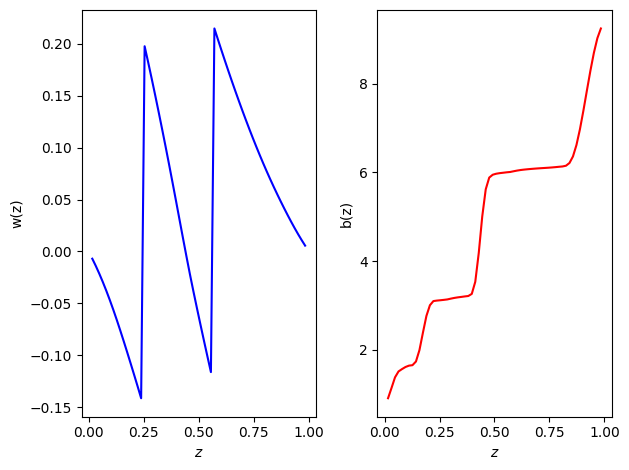

Iteration i = 1040, Residual error r_i = 1.015807e-03 



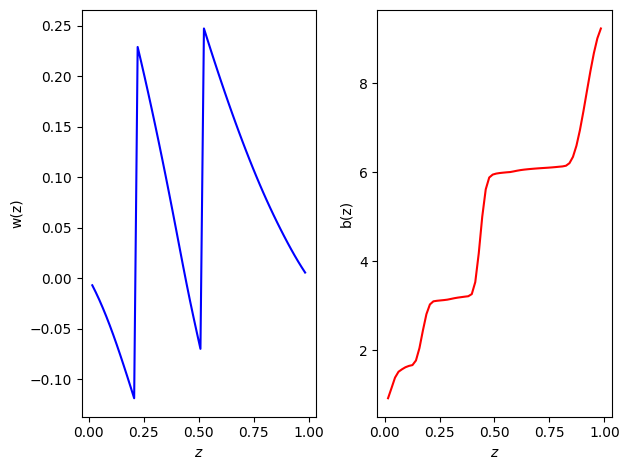

Iteration i = 1050, Residual error r_i = 8.642766e-04 



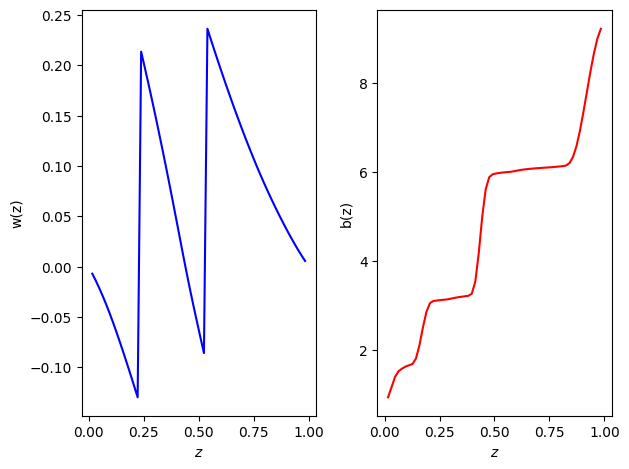

Iteration i = 1060, Residual error r_i = 8.440612e-04 



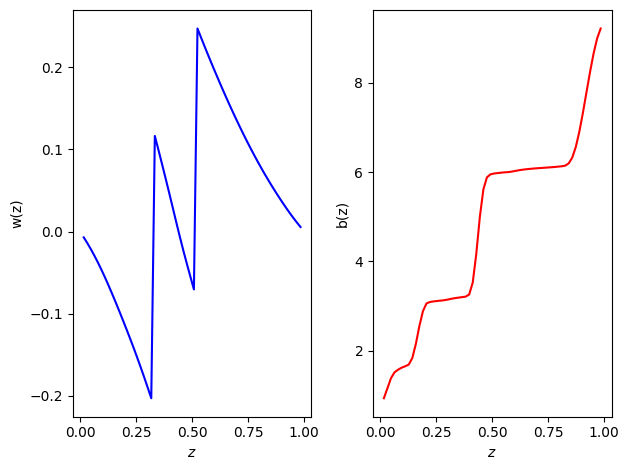

Iteration i = 1070, Residual error r_i = 8.694631e-04 



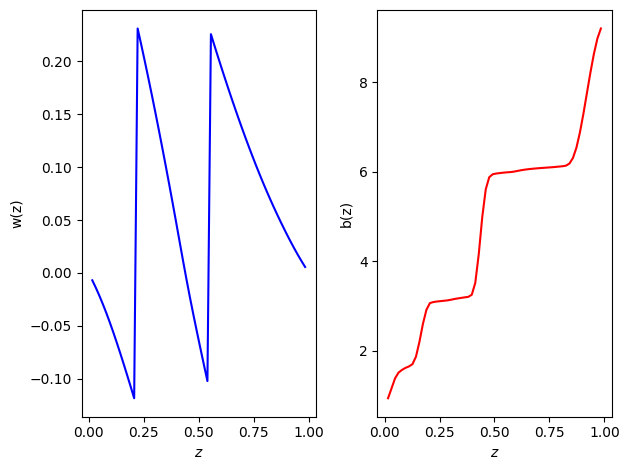

Iteration i = 1080, Residual error r_i = 3.618482e-03 



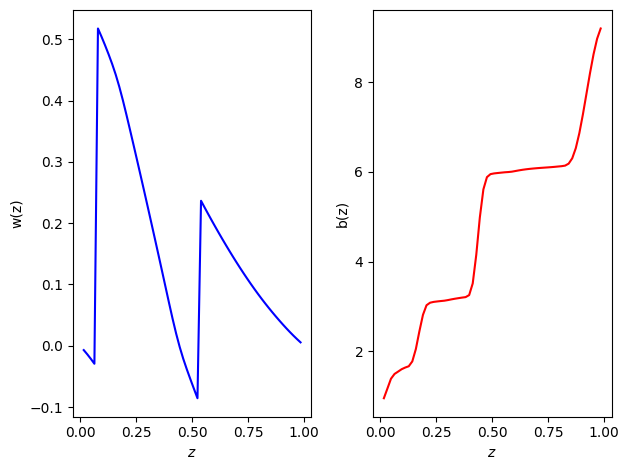

Iteration i = 1090, Residual error r_i = 3.565403e-03 



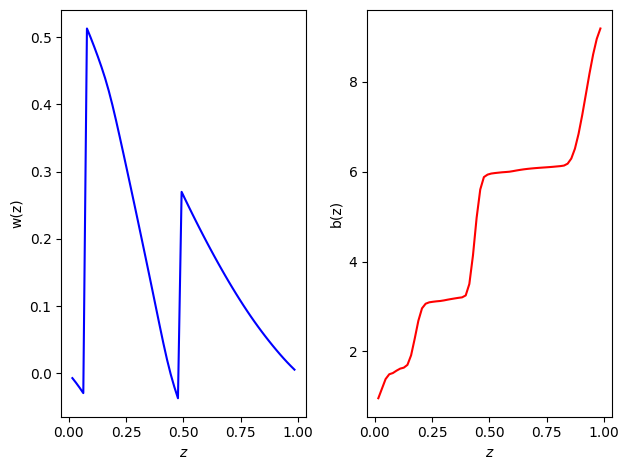

Iteration i = 1100, Residual error r_i = 3.488704e-03 



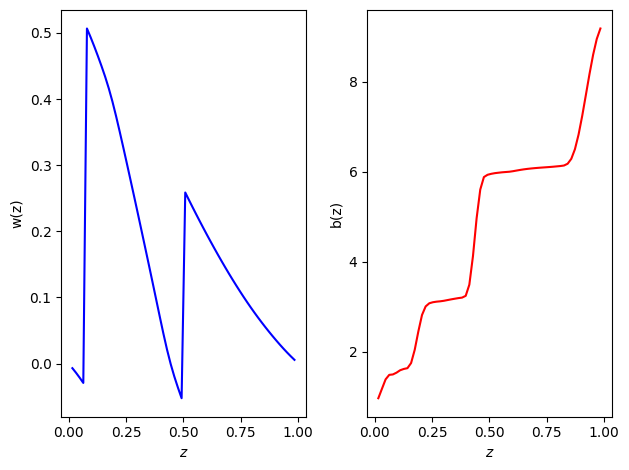

Iteration i = 1110, Residual error r_i = 9.591145e-04 



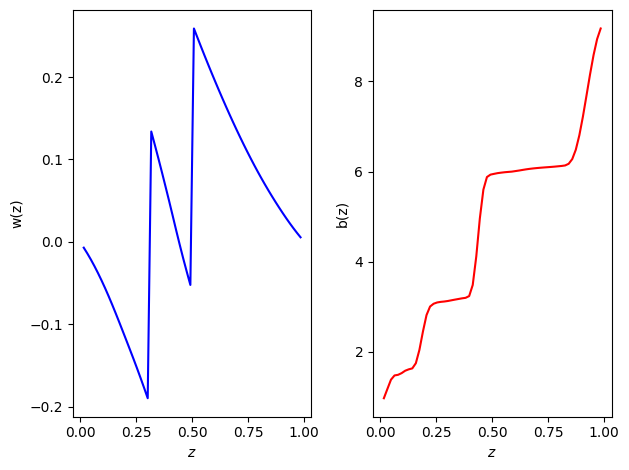

Iteration i = 1120, Residual error r_i = 9.444674e-04 



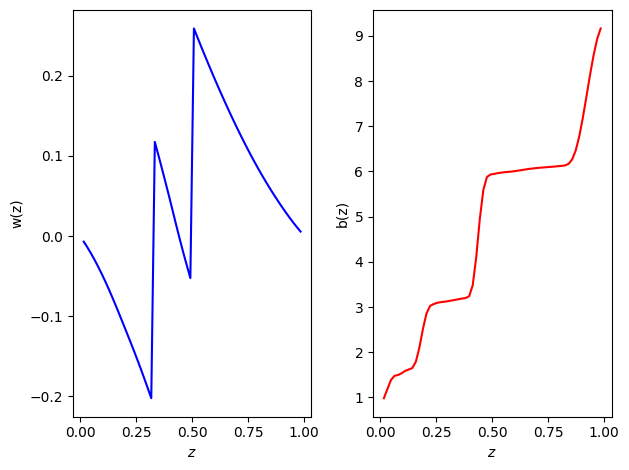

Iteration i = 1130, Residual error r_i = 9.284070e-04 



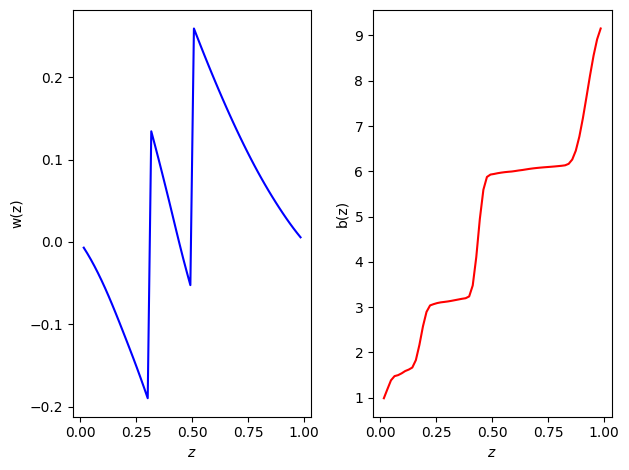

Iteration i = 1140, Residual error r_i = 1.230227e-03 



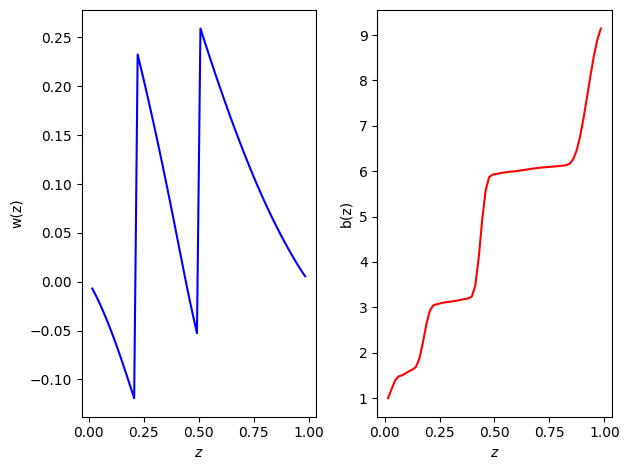

Iteration i = 1150, Residual error r_i = 9.019695e-04 



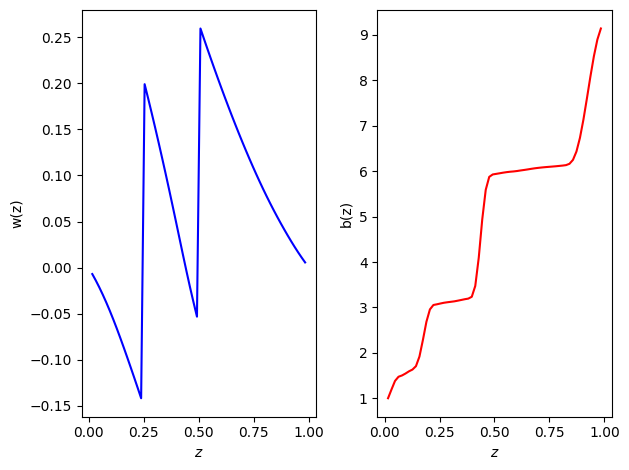

Iteration i = 1160, Residual error r_i = 8.741929e-04 



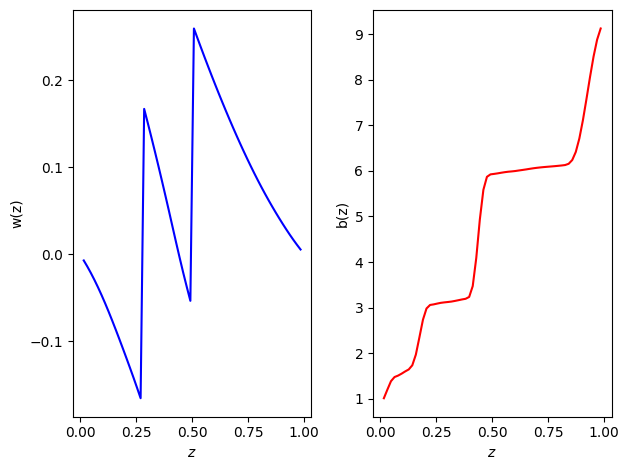

Iteration i = 1170, Residual error r_i = 9.821393e-04 



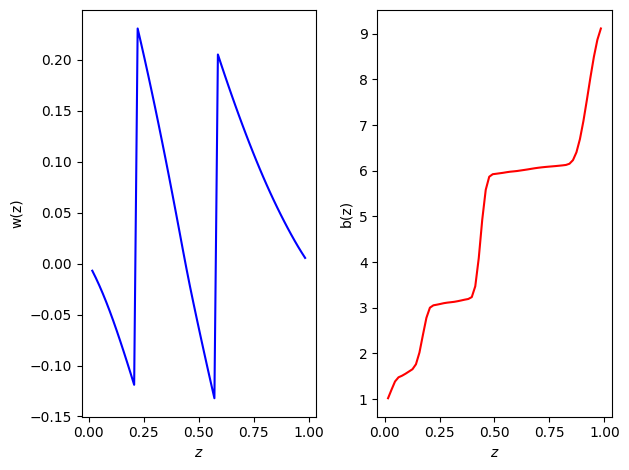

Iteration i = 1180, Residual error r_i = 8.468397e-04 



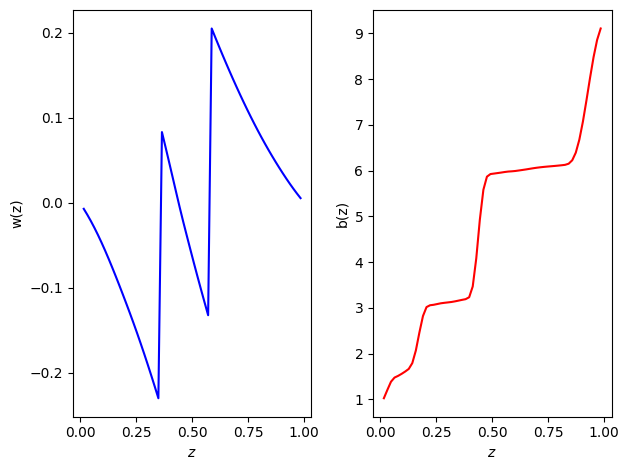

Iteration i = 1190, Residual error r_i = 8.872388e-04 



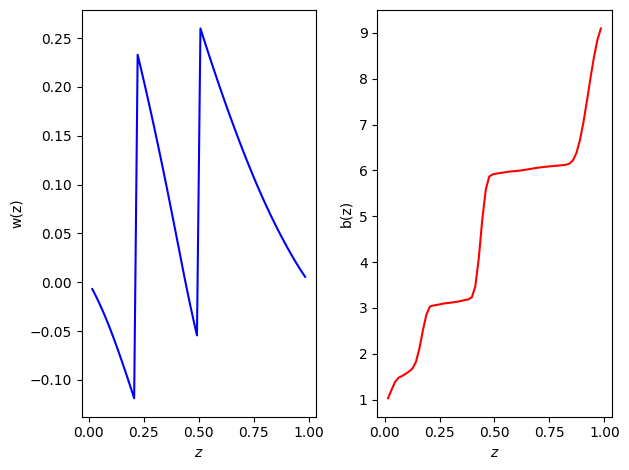

Iteration i = 1200, Residual error r_i = 1.222393e-03 



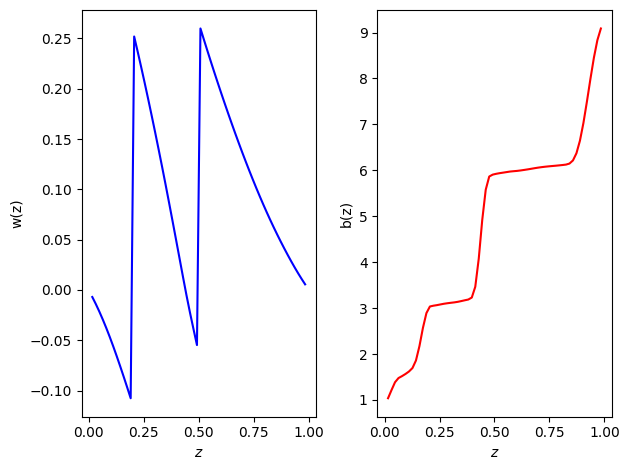

Iteration i = 1210, Residual error r_i = 8.053555e-04 



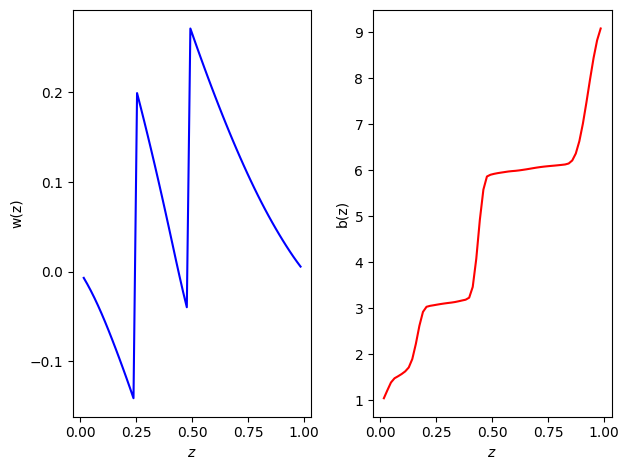

Iteration i = 1220, Residual error r_i = 3.435421e-03 



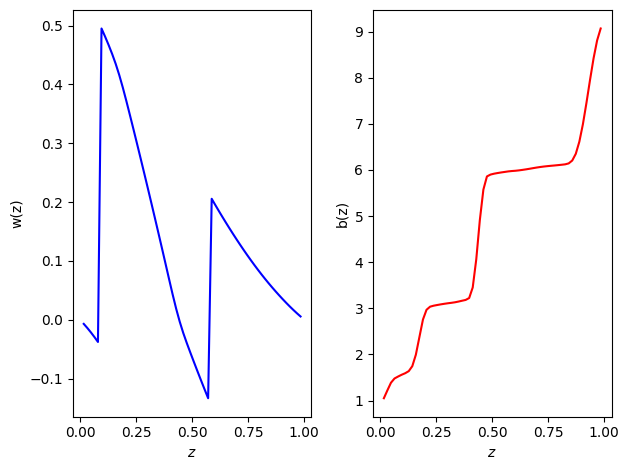

Iteration i = 1230, Residual error r_i = 3.398112e-03 



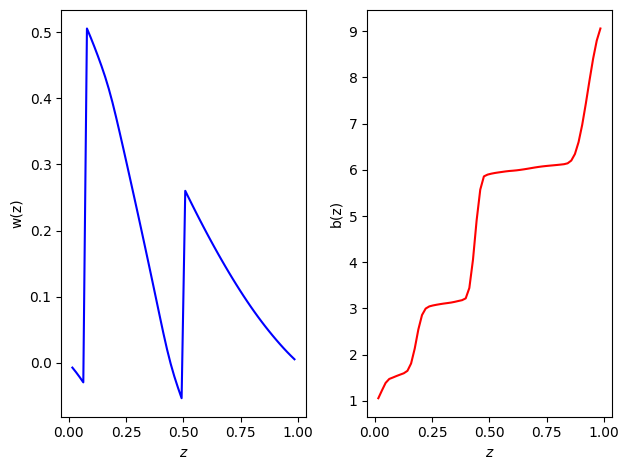

Iteration i = 1240, Residual error r_i = 3.343400e-03 



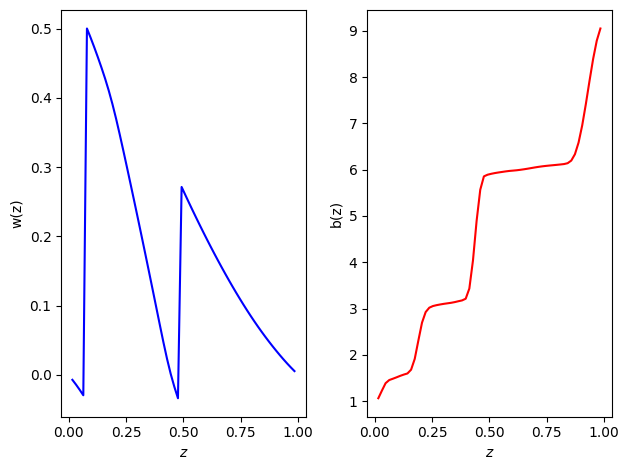

Iteration i = 1250, Residual error r_i = 3.273997e-03 



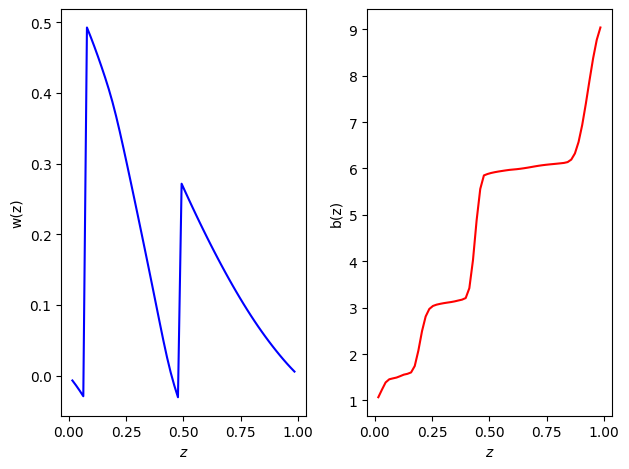

Iteration i = 1260, Residual error r_i = 3.205124e-03 



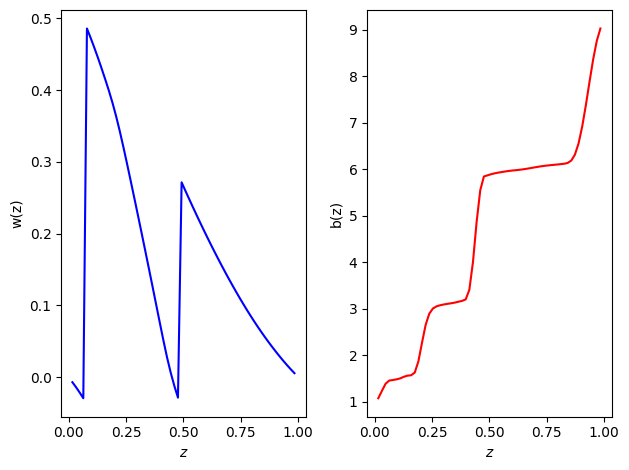

Iteration i = 1270, Residual error r_i = 3.288720e-03 



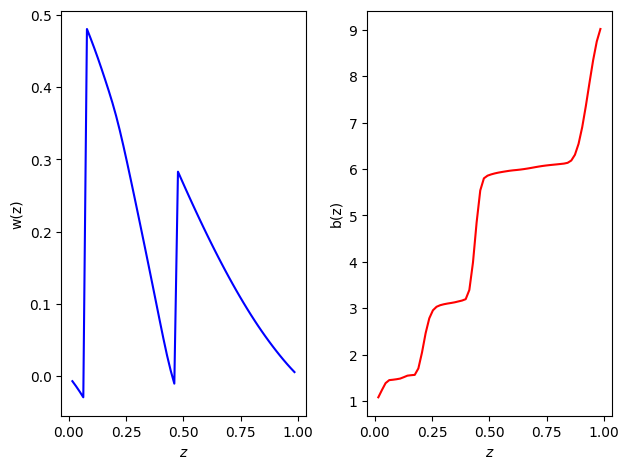

Iteration i = 1280, Residual error r_i = 3.065652e-03 



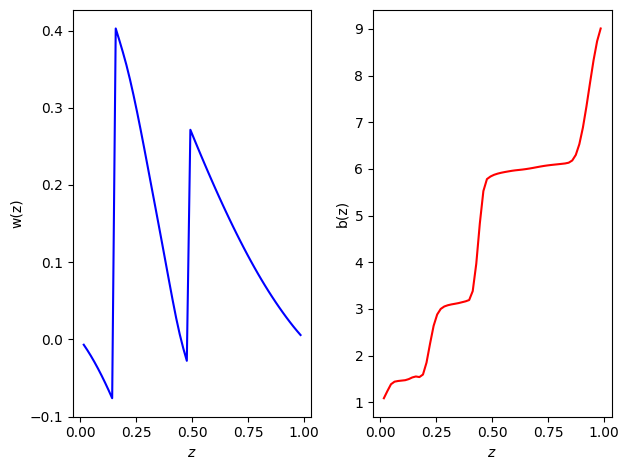

Iteration i = 1290, Residual error r_i = 1.791774e-03 



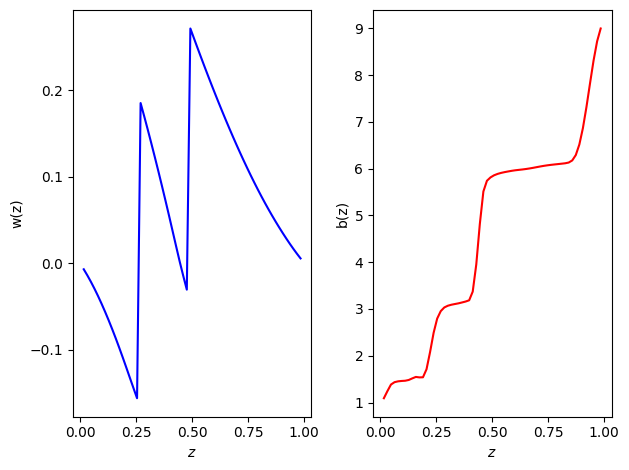

Iteration i = 1300, Residual error r_i = 1.376986e-03 



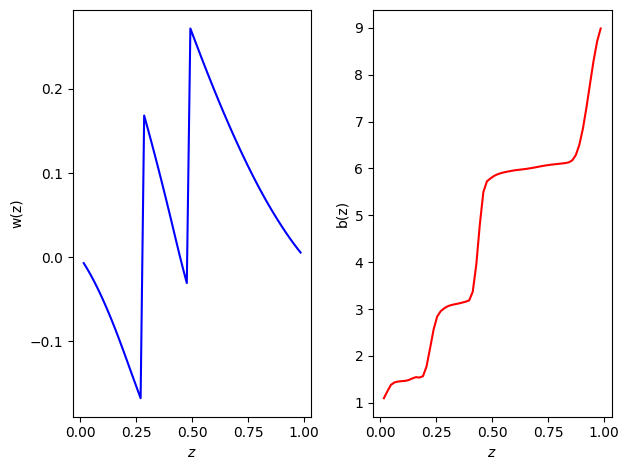

Iteration i = 1310, Residual error r_i = 1.493893e-03 



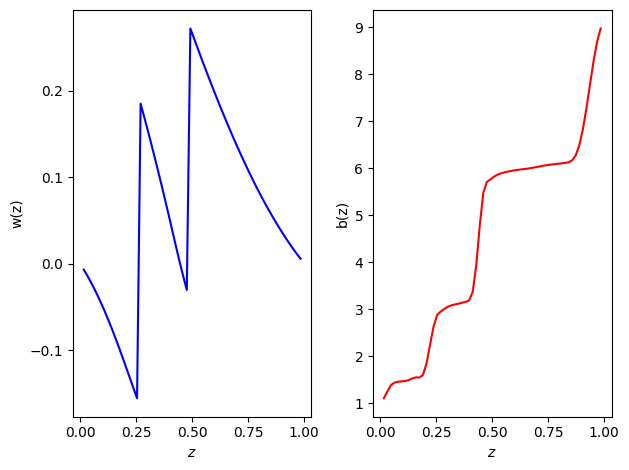

Iteration i = 1320, Residual error r_i = 1.244859e-03 



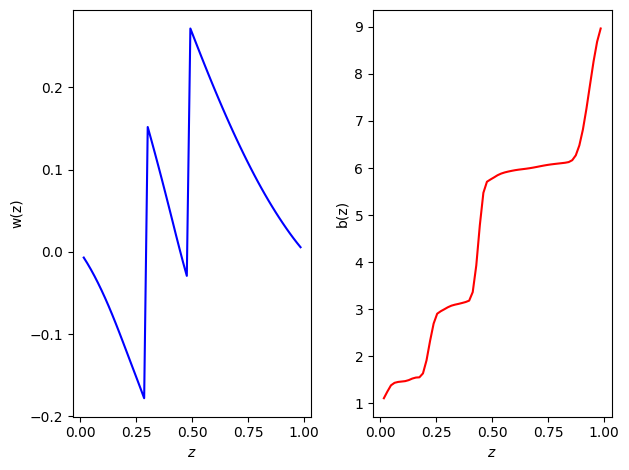

Iteration i = 1330, Residual error r_i = 1.339439e-03 



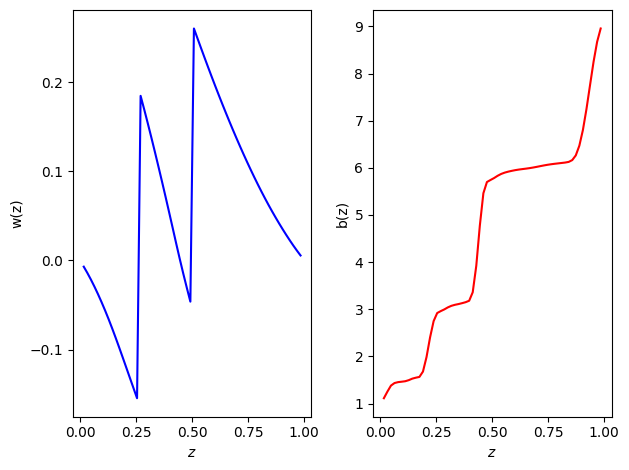

Iteration i = 1340, Residual error r_i = 1.271850e-03 



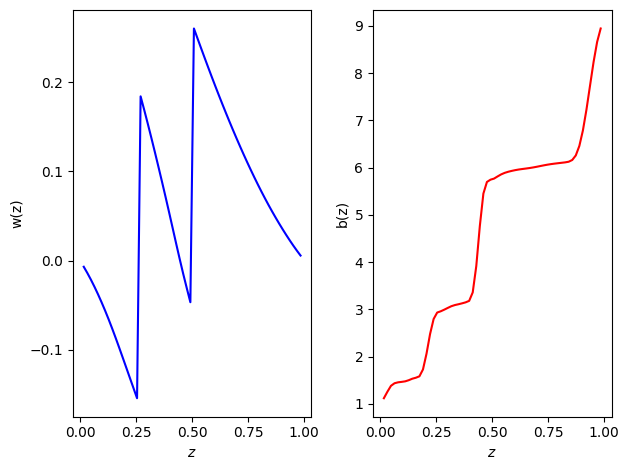

Iteration i = 1350, Residual error r_i = 3.081352e-03 



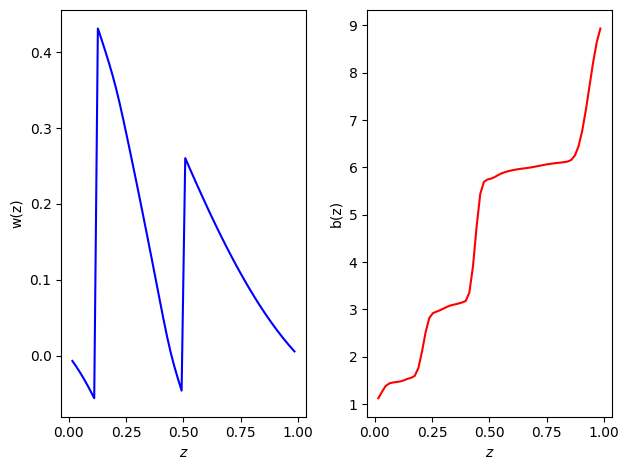

Iteration i = 1360, Residual error r_i = 3.099378e-03 



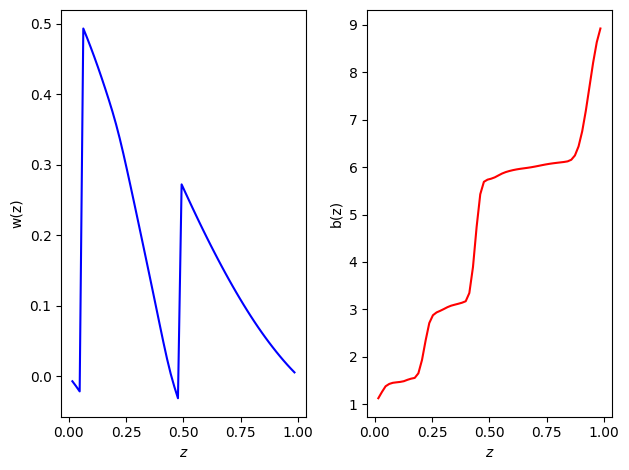

Iteration i = 1370, Residual error r_i = 3.022827e-03 



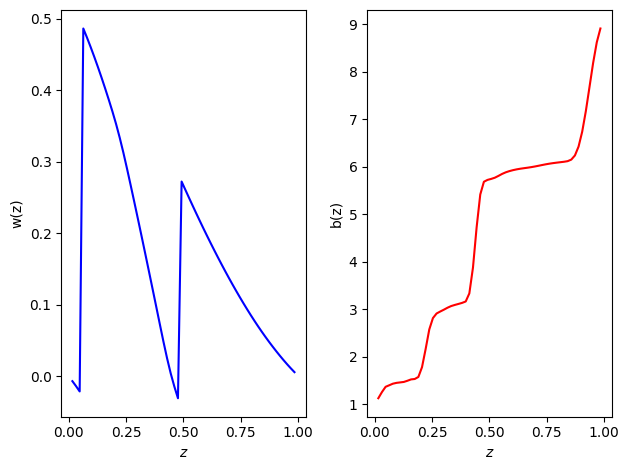

Iteration i = 1380, Residual error r_i = 2.959635e-03 



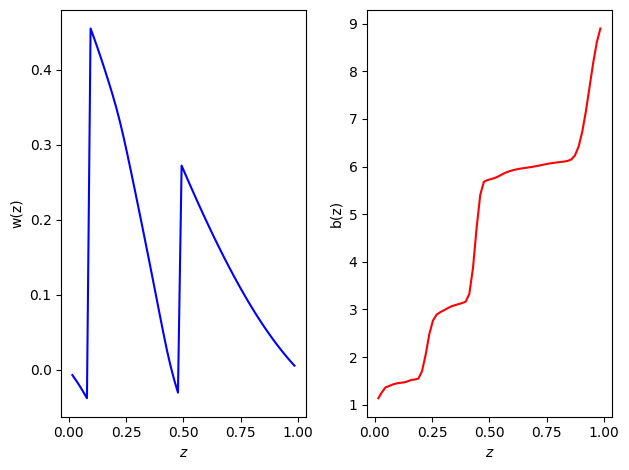

Iteration i = 1390, Residual error r_i = 2.962911e-03 



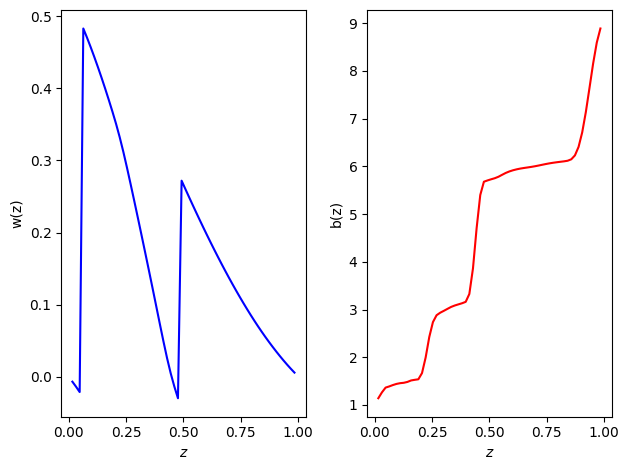

Iteration i = 1400, Residual error r_i = 1.482365e-03 



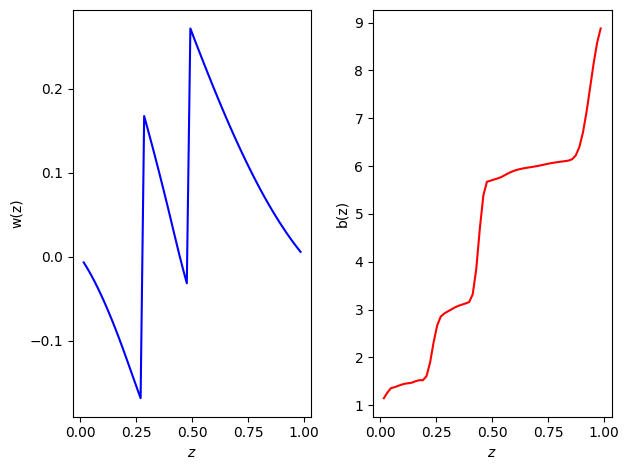

Iteration i = 1410, Residual error r_i = 1.443969e-03 



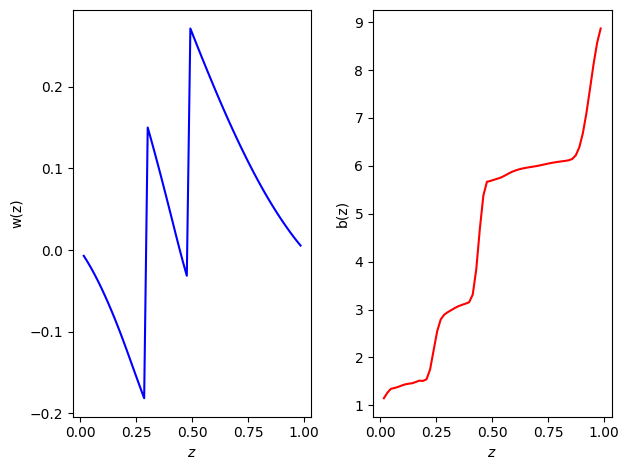

Iteration i = 1420, Residual error r_i = 2.864238e-03 



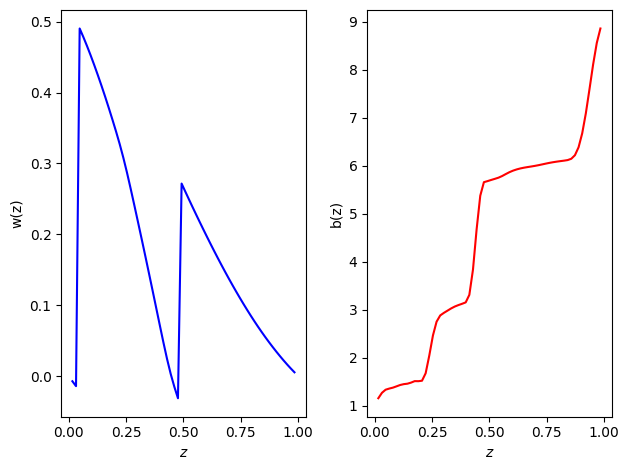

Iteration i = 1430, Residual error r_i = 2.772375e-03 



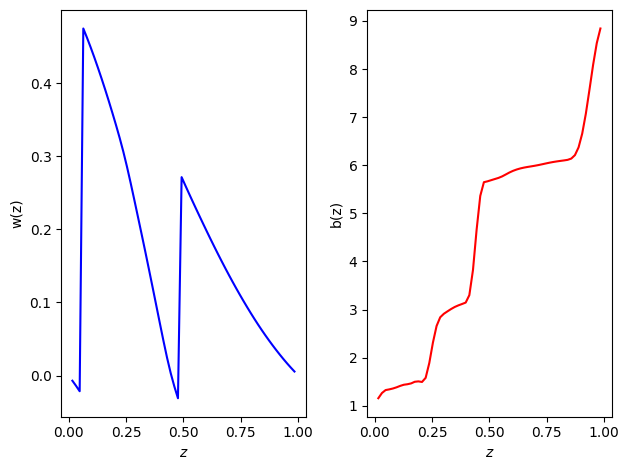

Iteration i = 1440, Residual error r_i = 2.885448e-03 



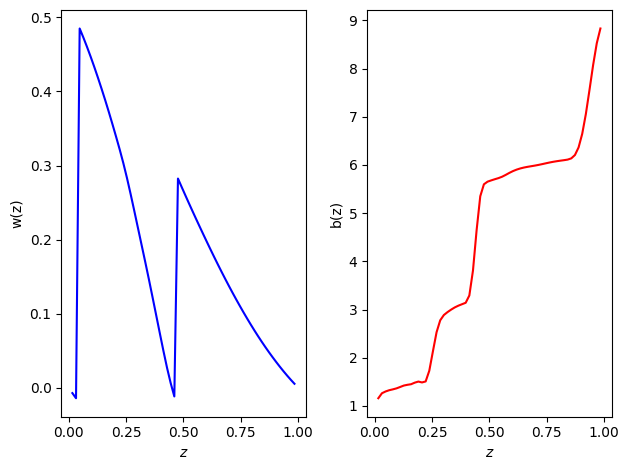

Iteration i = 1450, Residual error r_i = 2.862886e-03 



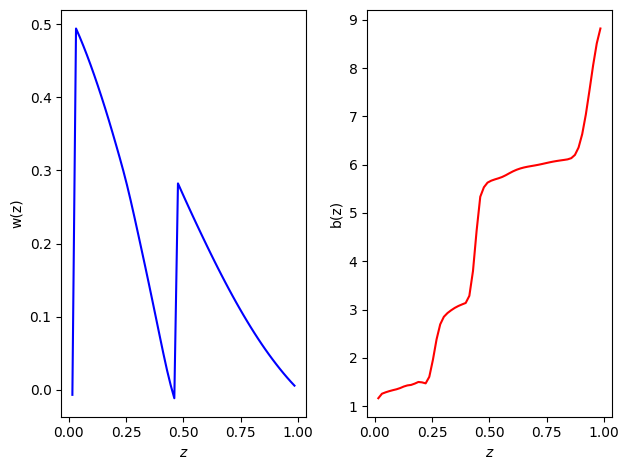

Iteration i = 1460, Residual error r_i = 1.758836e-03 



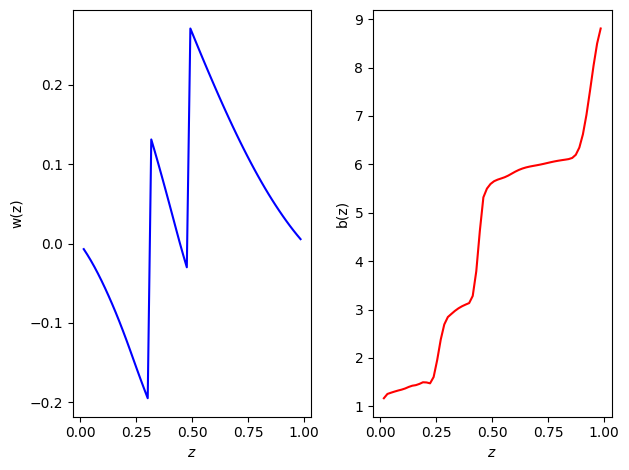

Iteration i = 1470, Residual error r_i = 1.884197e-03 



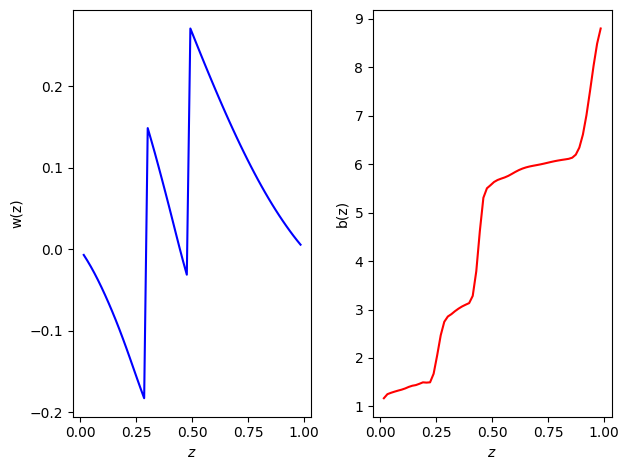

Iteration i = 1480, Residual error r_i = 1.746152e-03 



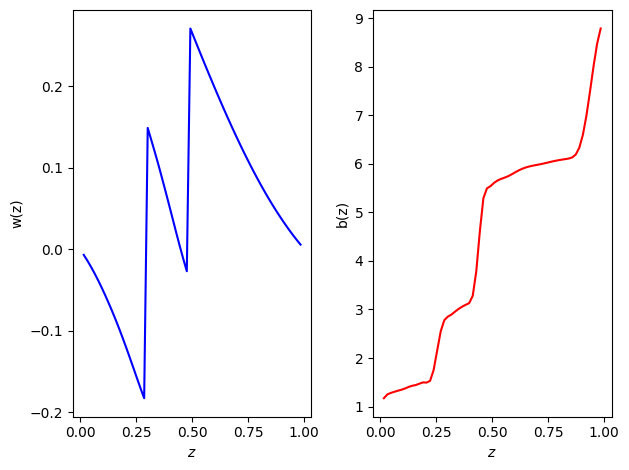

Iteration i = 1490, Residual error r_i = 1.638785e-03 



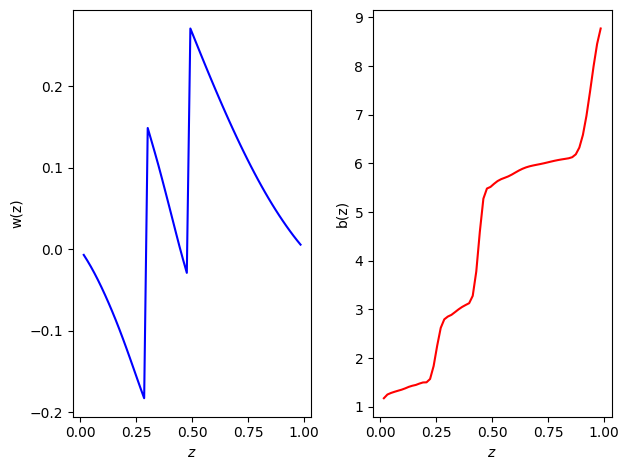

Iteration i = 1500, Residual error r_i = 1.835395e-03 



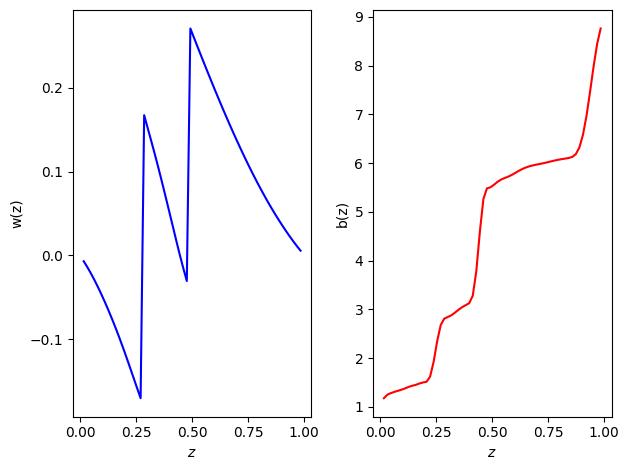

Iteration i = 1510, Residual error r_i = 1.695303e-03 



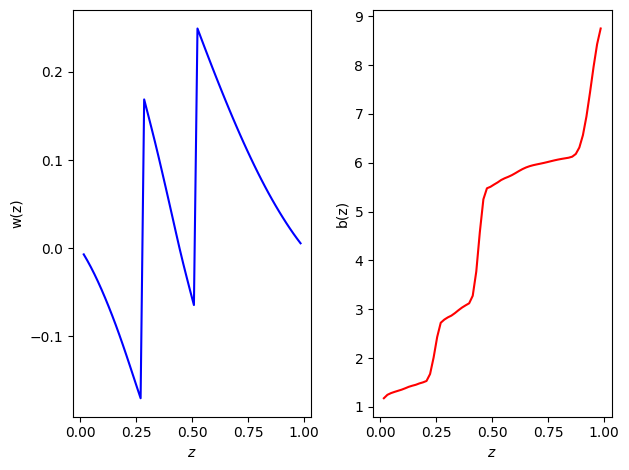

Iteration i = 1520, Residual error r_i = 2.057723e-03 



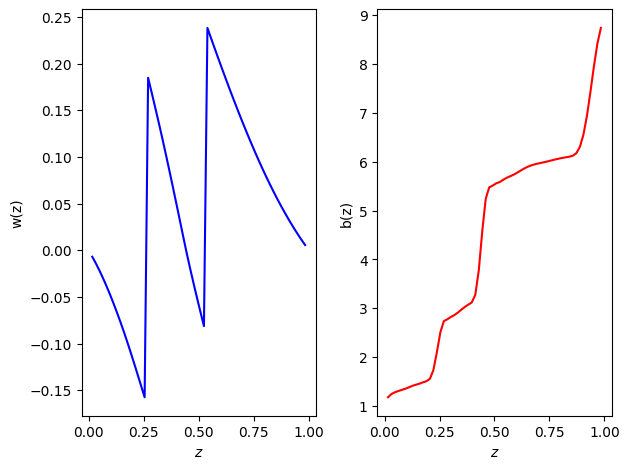

Iteration i = 1530, Residual error r_i = 1.809766e-03 



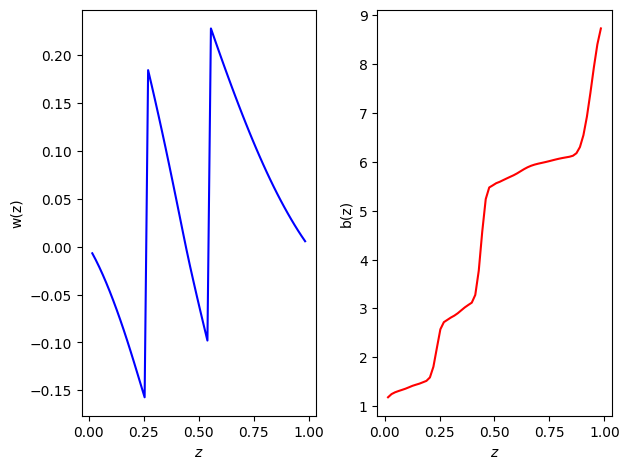

Iteration i = 1540, Residual error r_i = 1.382933e-03 



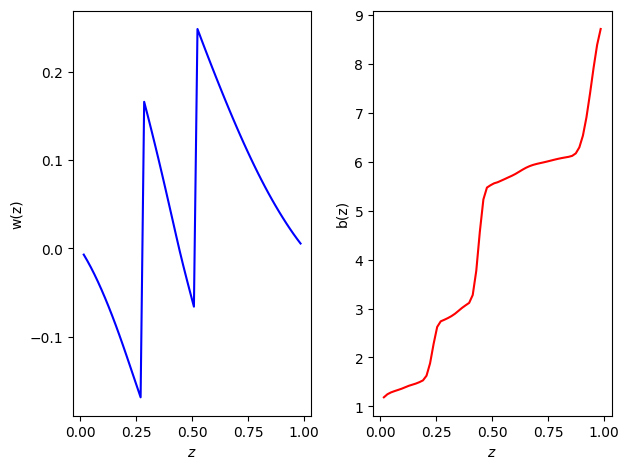

Iteration i = 1550, Residual error r_i = 1.514402e-03 



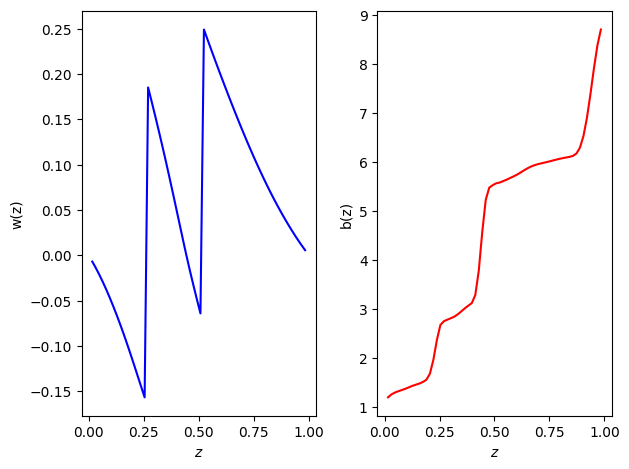

Iteration i = 1560, Residual error r_i = 1.248952e-03 



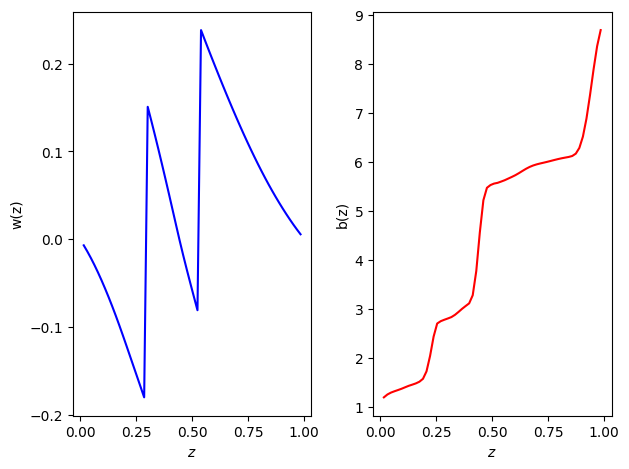

Iteration i = 1570, Residual error r_i = 1.218510e-03 



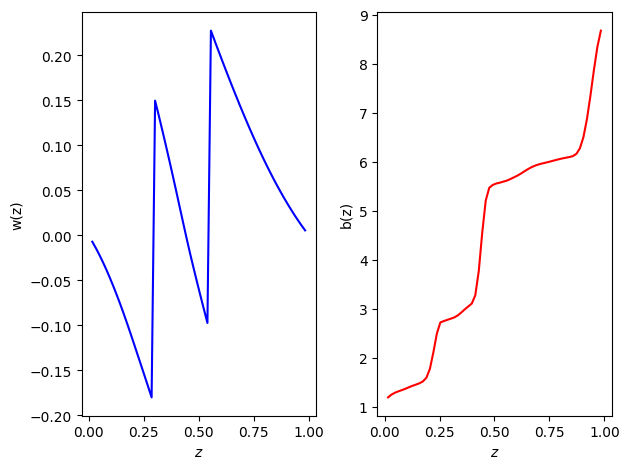

Iteration i = 1580, Residual error r_i = 1.235790e-03 



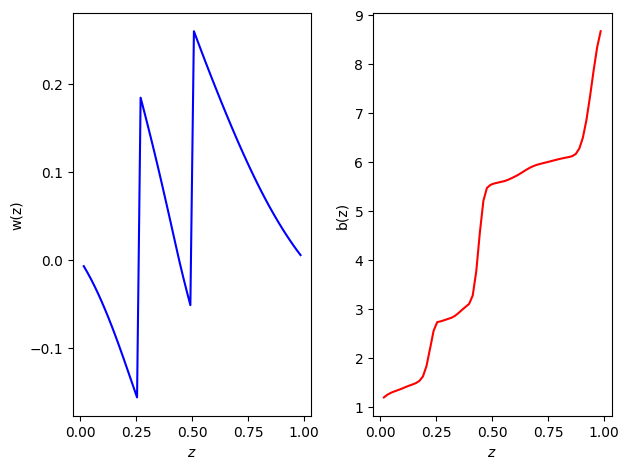

Iteration i = 1590, Residual error r_i = 1.146648e-03 



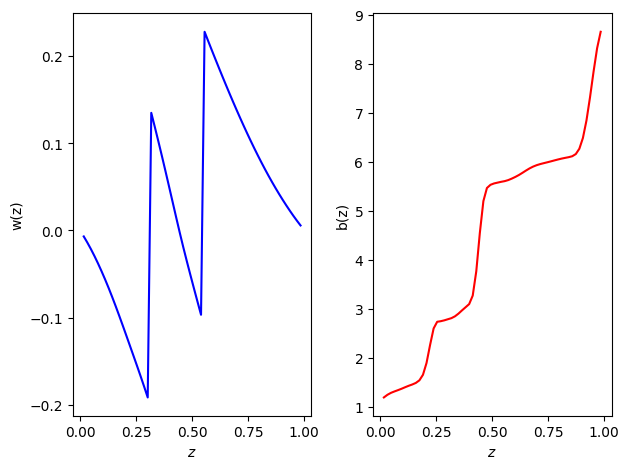

Iteration i = 1600, Residual error r_i = 1.131466e-03 



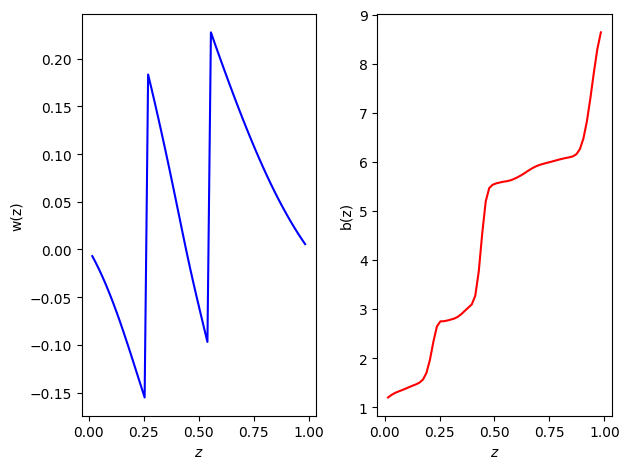

Iteration i = 1610, Residual error r_i = 1.096245e-03 



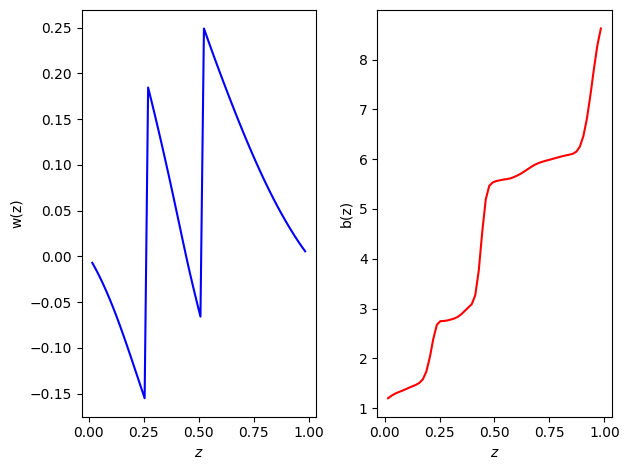

Iteration i = 1620, Residual error r_i = 1.150868e-03 



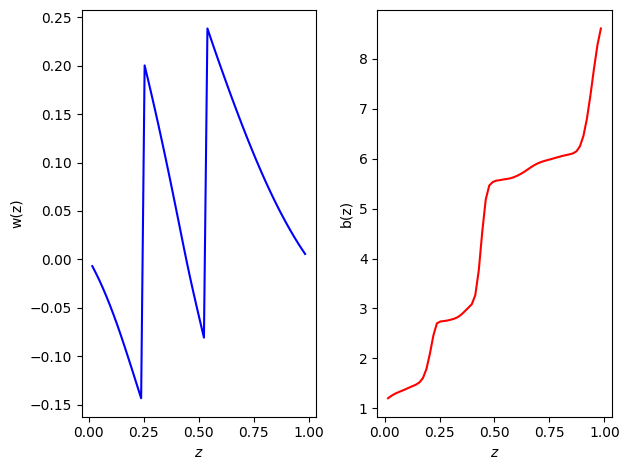

Iteration i = 1630, Residual error r_i = 1.082881e-03 



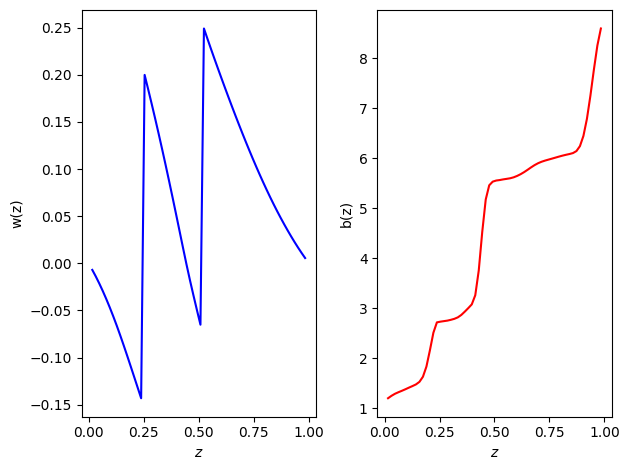

Iteration i = 1640, Residual error r_i = 1.032555e-03 



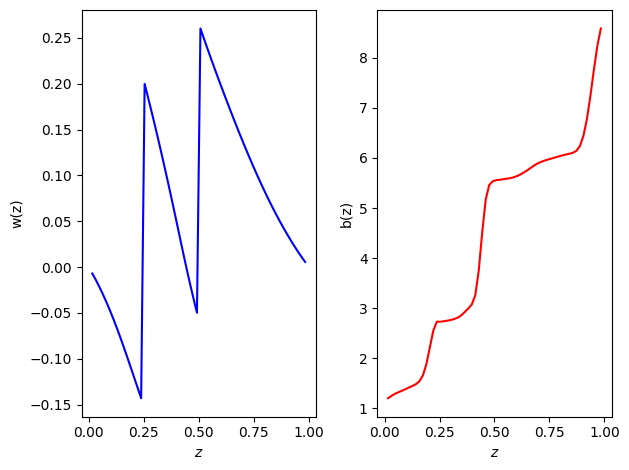

Iteration i = 1650, Residual error r_i = 9.931020e-04 



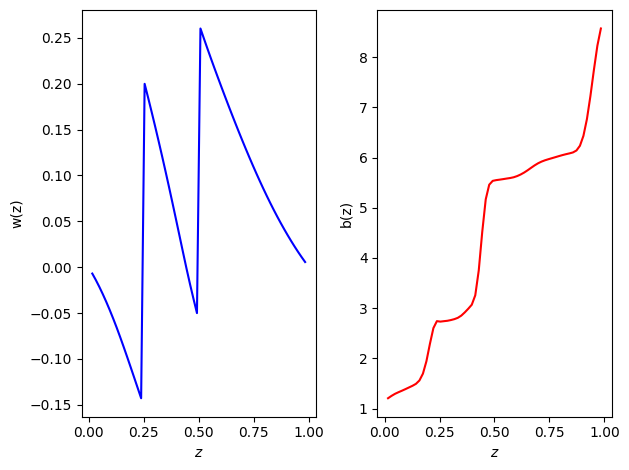

Iteration i = 1660, Residual error r_i = 1.183211e-03 



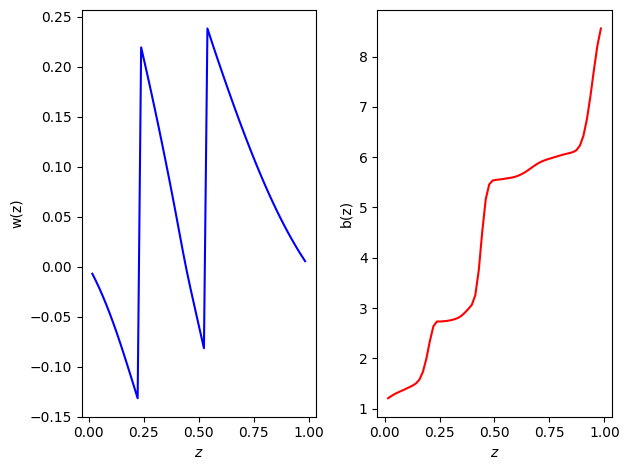

Iteration i = 1670, Residual error r_i = 1.089018e-03 



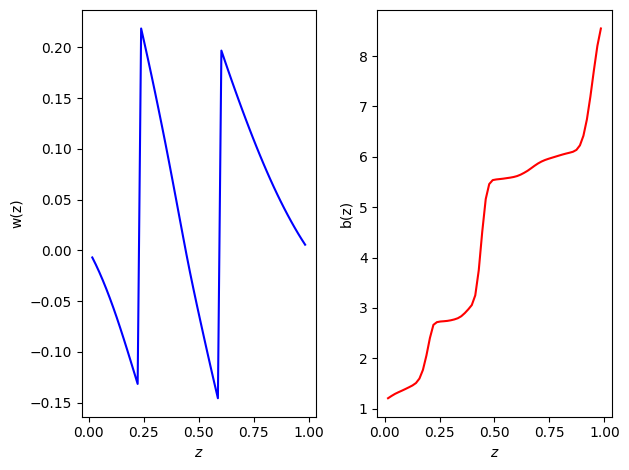

Iteration i = 1680, Residual error r_i = 1.018178e-03 



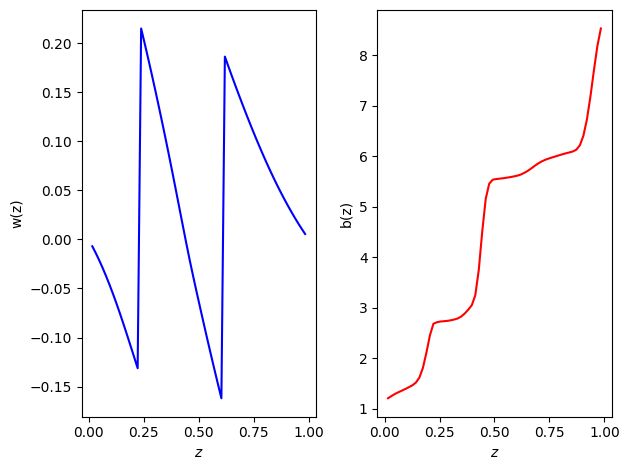

Iteration i = 1690, Residual error r_i = 9.578866e-04 



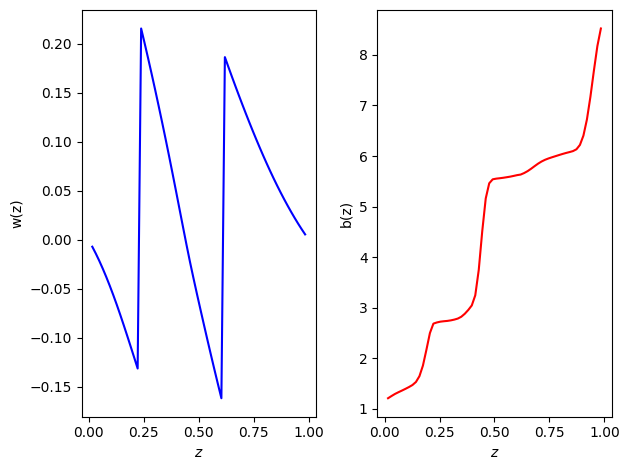

Iteration i = 1700, Residual error r_i = 1.315760e-03 



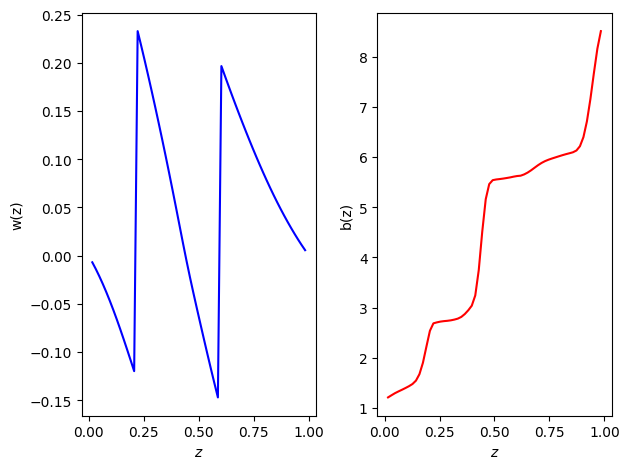

Iteration i = 1710, Residual error r_i = 8.724002e-04 



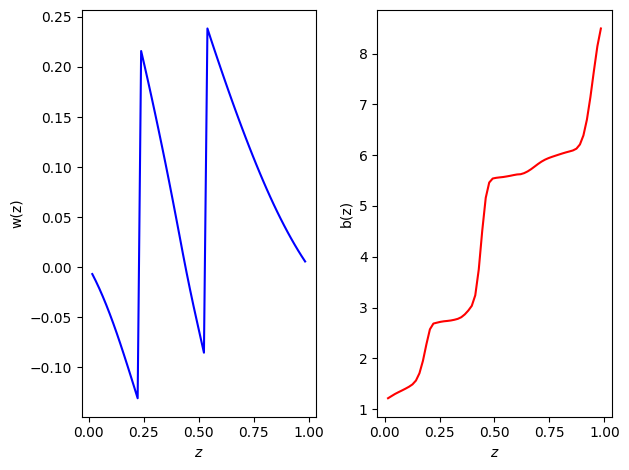

Iteration i = 1720, Residual error r_i = 1.073864e-03 



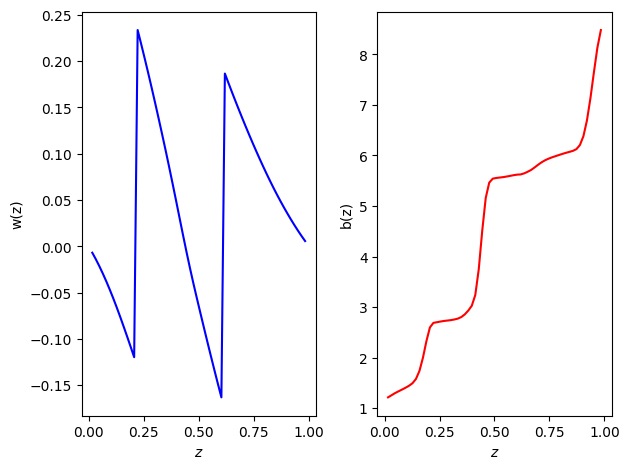

Iteration i = 1730, Residual error r_i = 8.198091e-04 



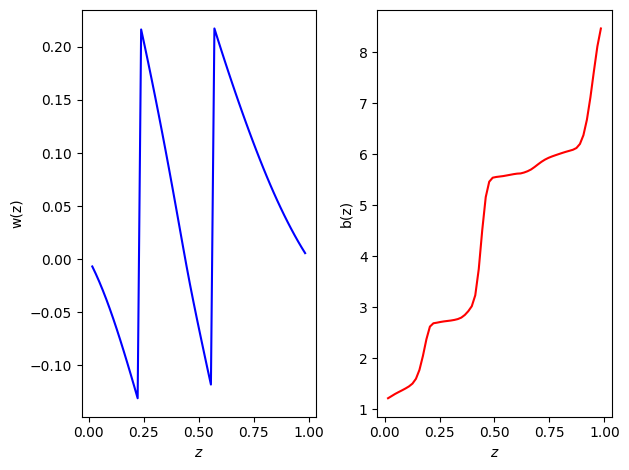

Iteration i = 1740, Residual error r_i = 7.851636e-04 



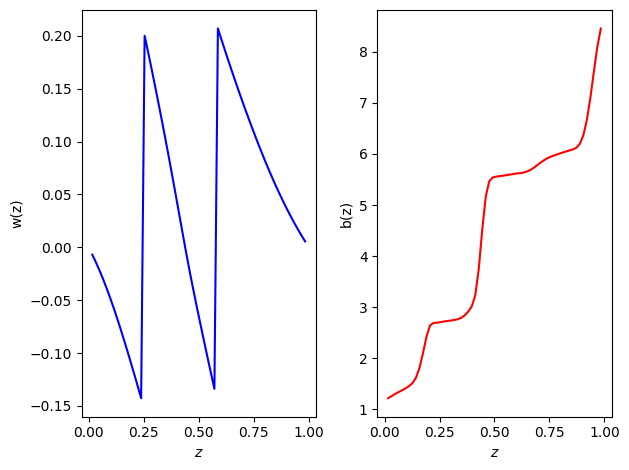

Iteration i = 1750, Residual error r_i = 8.839370e-04 



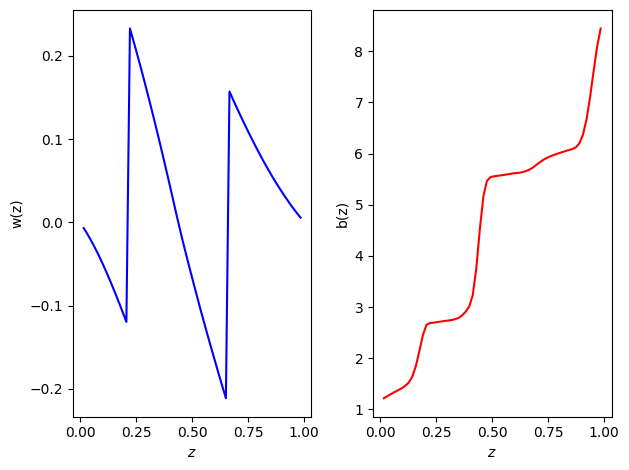

Iteration i = 1760, Residual error r_i = 1.324087e-03 



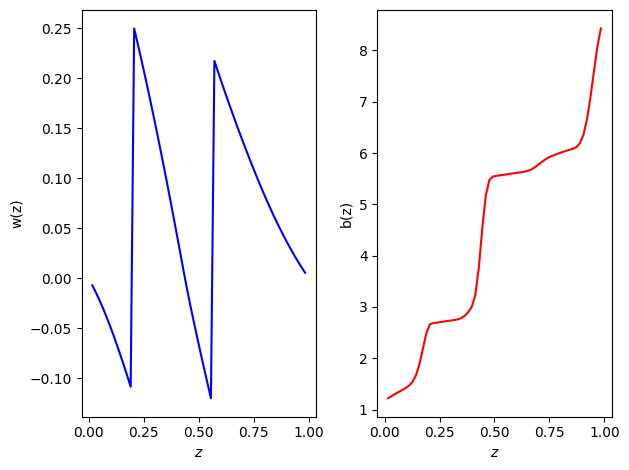

Iteration i = 1770, Residual error r_i = 7.455917e-04 



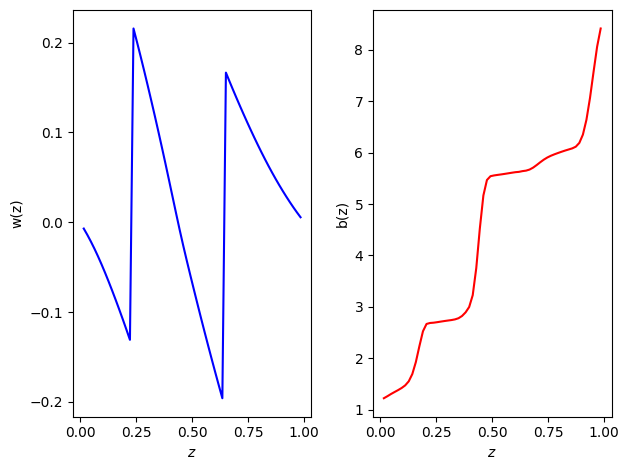

Iteration i = 1780, Residual error r_i = 1.078280e-03 



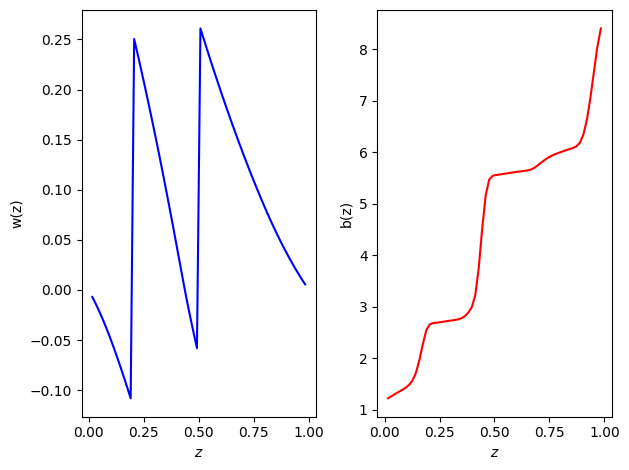

Iteration i = 1790, Residual error r_i = 9.849357e-04 



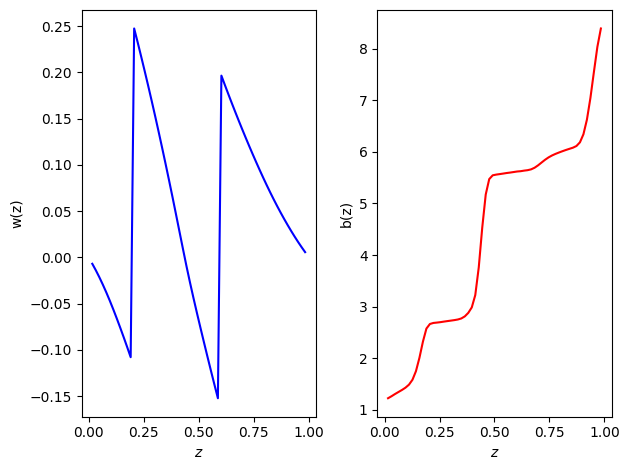

Iteration i = 1800, Residual error r_i = 9.006977e-04 



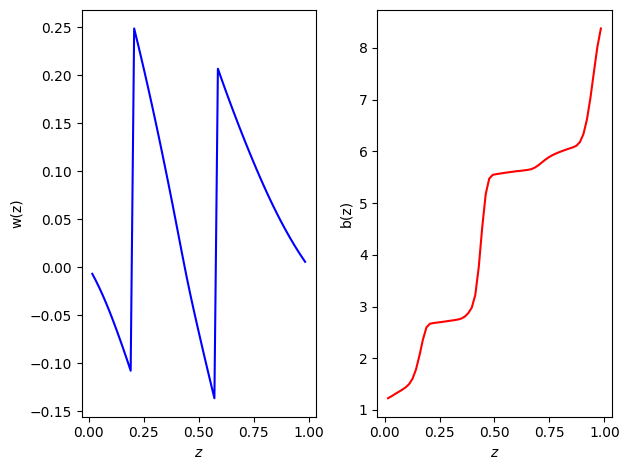

Iteration i = 1810, Residual error r_i = 6.737144e-04 



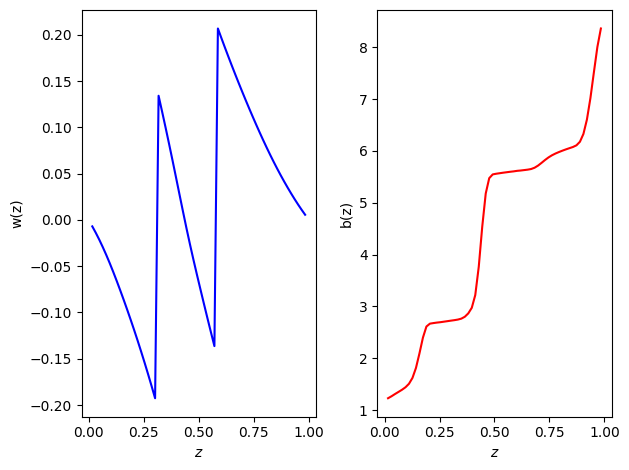

Iteration i = 1820, Residual error r_i = 6.624930e-04 



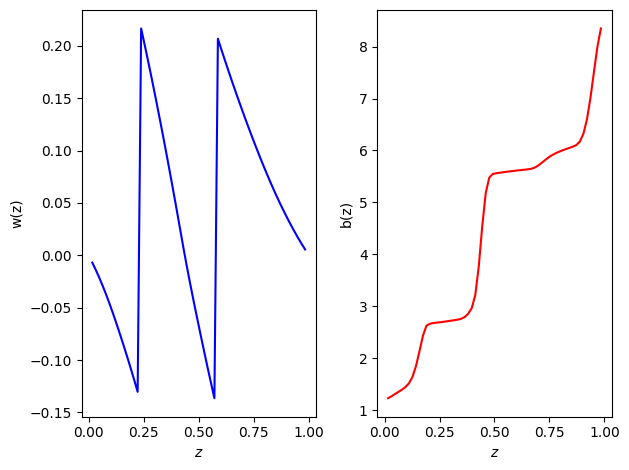

Iteration i = 1830, Residual error r_i = 7.341820e-04 



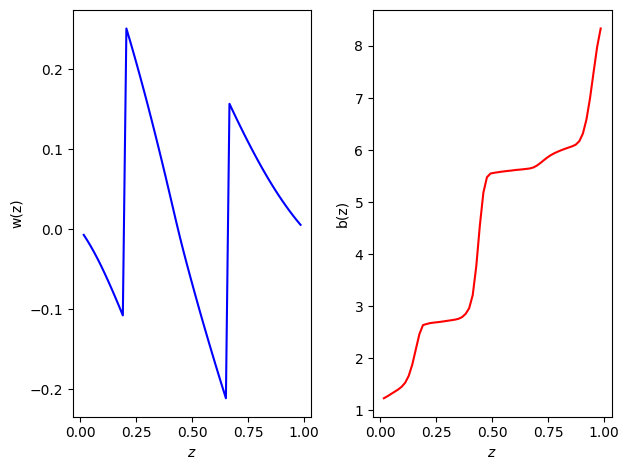

Iteration i = 1840, Residual error r_i = 6.448624e-04 



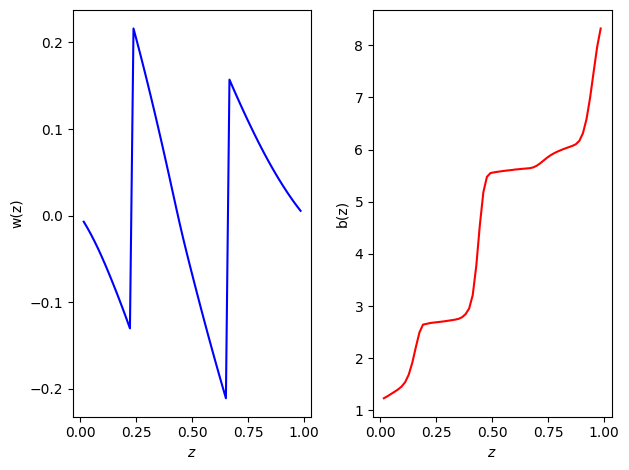

Iteration i = 1850, Residual error r_i = 6.739736e-04 



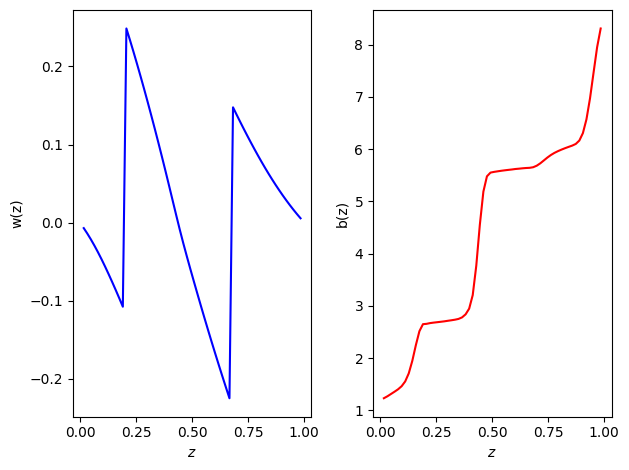

Iteration i = 1860, Residual error r_i = 6.482158e-04 



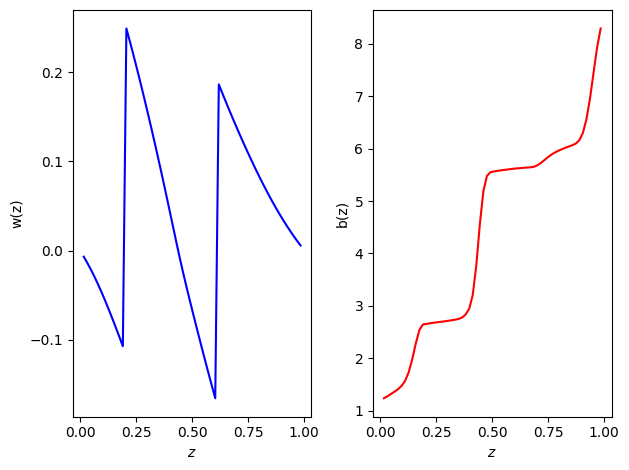

Iteration i = 1870, Residual error r_i = 6.274982e-04 



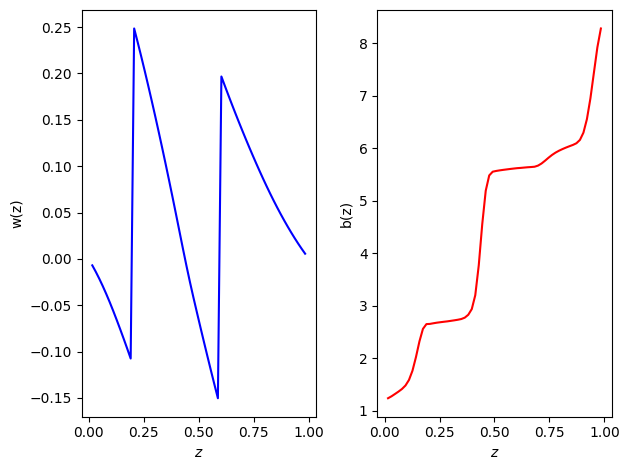

Iteration i = 1880, Residual error r_i = 7.900985e-04 



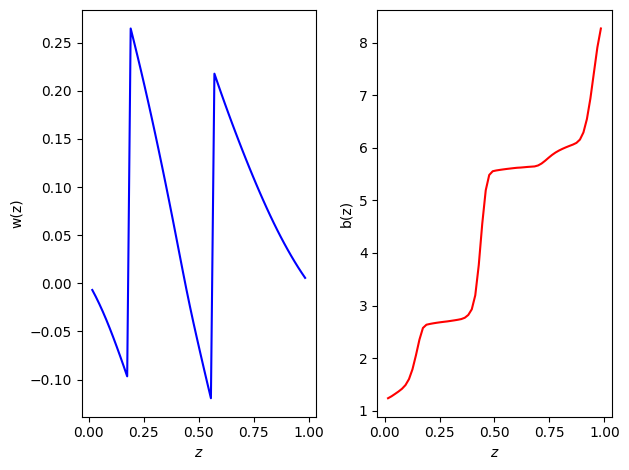

Iteration i = 1890, Residual error r_i = 7.295886e-04 



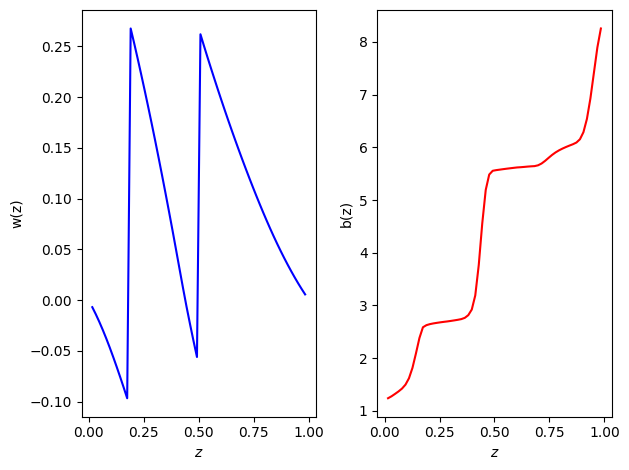

Iteration i = 1900, Residual error r_i = 5.853355e-04 



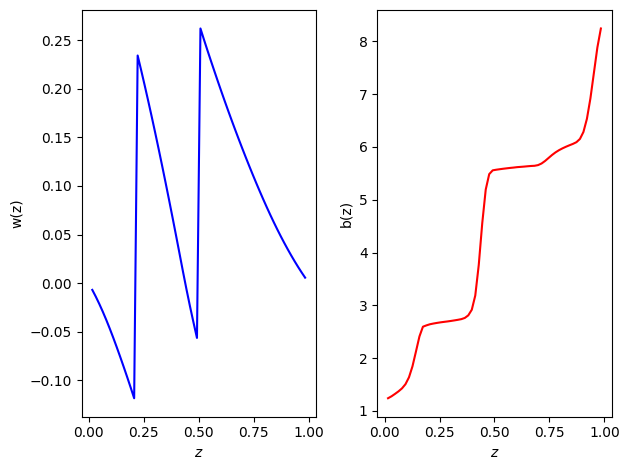

Iteration i = 1910, Residual error r_i = 6.456507e-04 



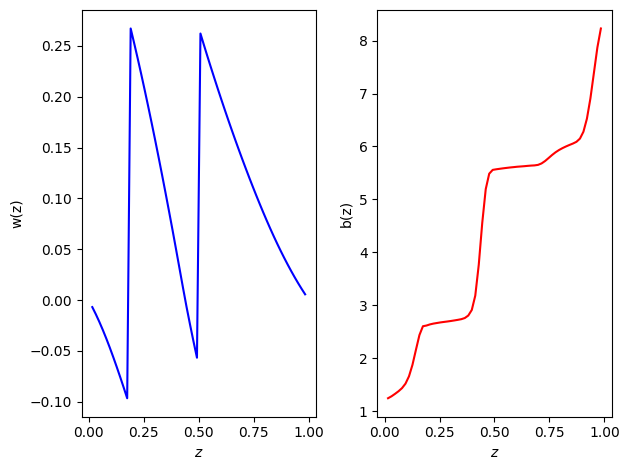

Iteration i = 1920, Residual error r_i = 2.886940e-03 



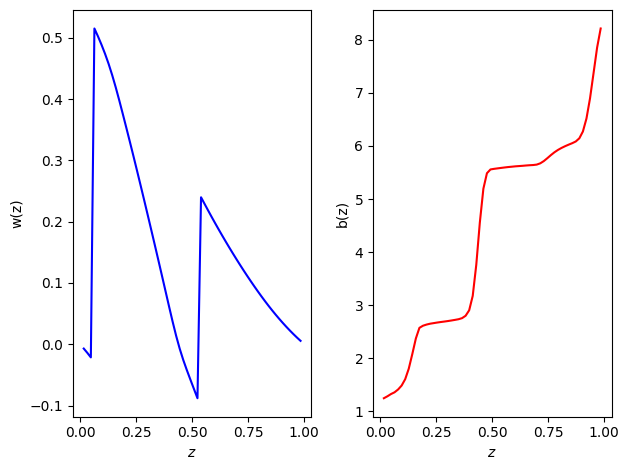

Iteration i = 1930, Residual error r_i = 5.830021e-04 



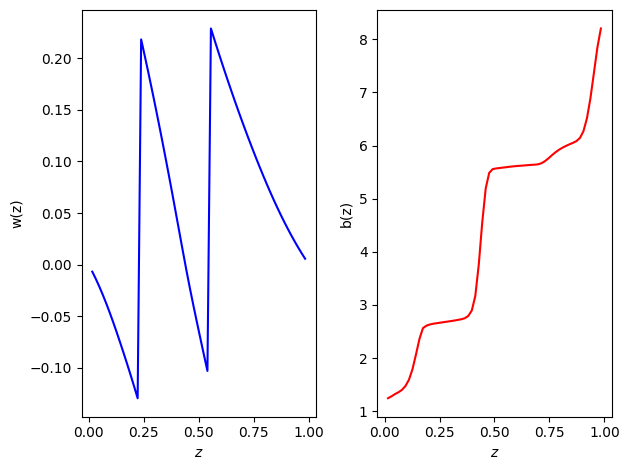

Iteration i = 1940, Residual error r_i = 6.386923e-04 



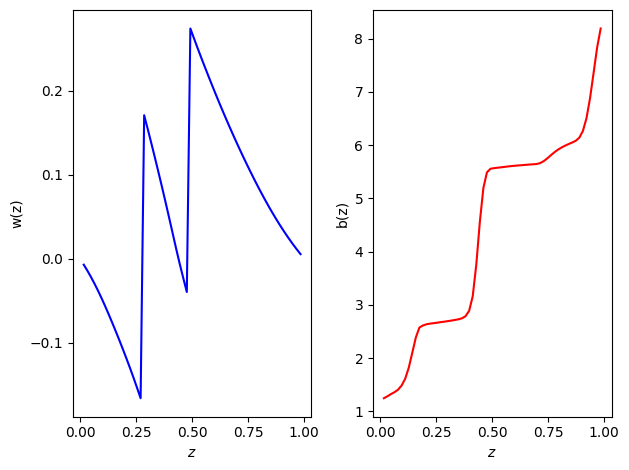

Iteration i = 1950, Residual error r_i = 6.707778e-04 



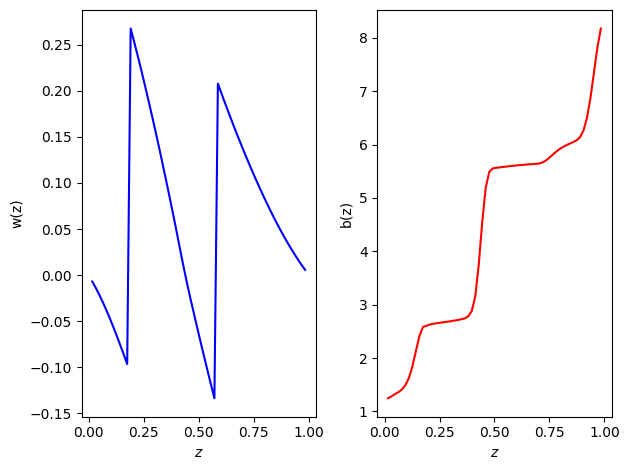

Iteration i = 1960, Residual error r_i = 5.638940e-04 



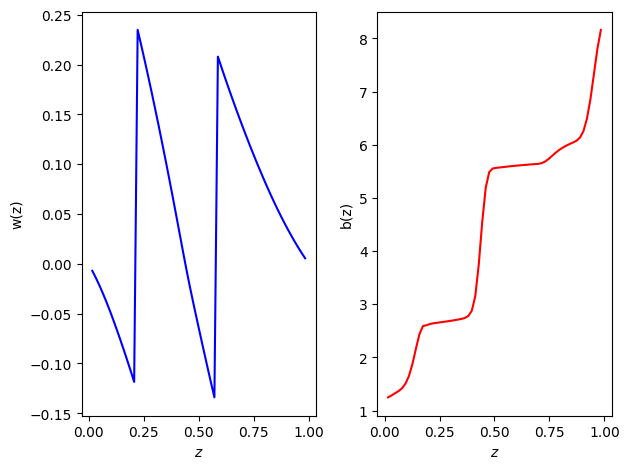

Iteration i = 1970, Residual error r_i = 5.682140e-04 



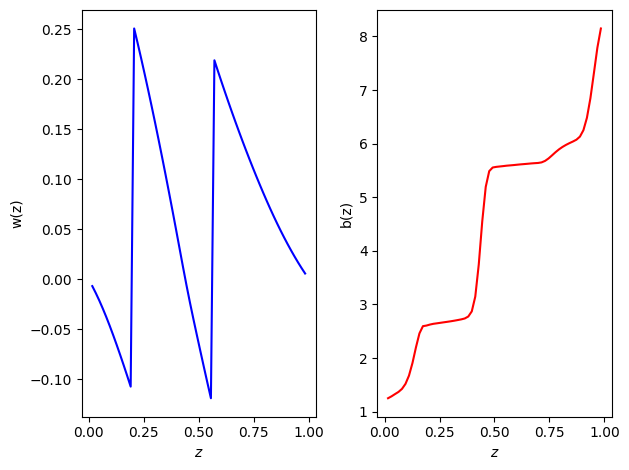

Iteration i = 1980, Residual error r_i = 5.563870e-04 



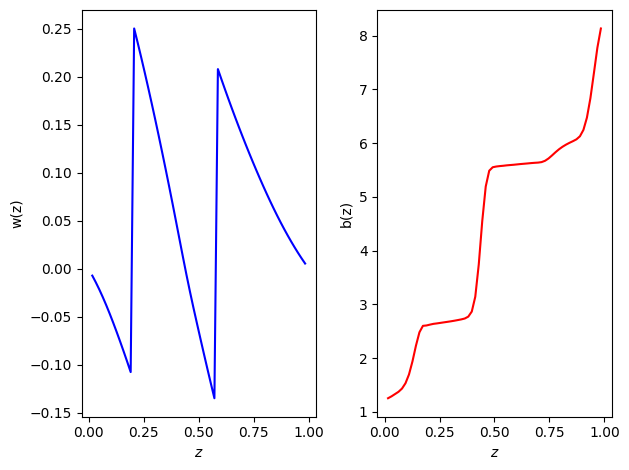

Iteration i = 1990, Residual error r_i = 5.318681e-04 



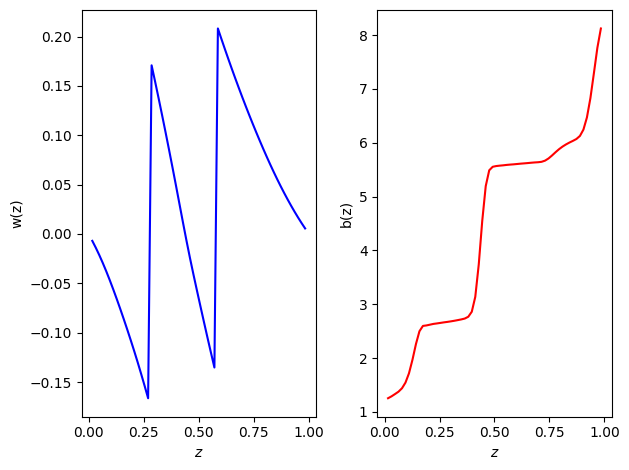

Iteration i = 2000, Residual error r_i = 7.867713e-04 



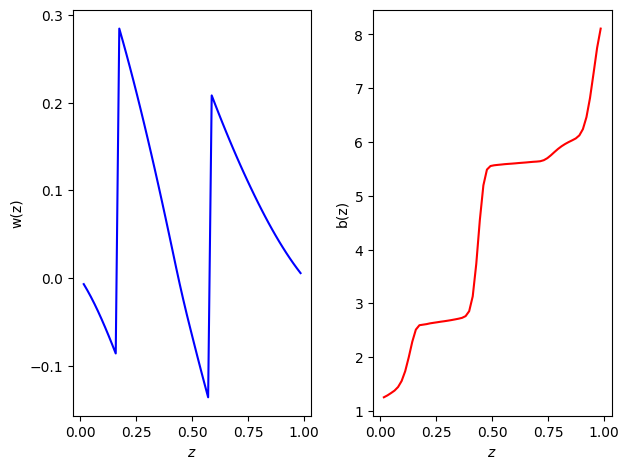

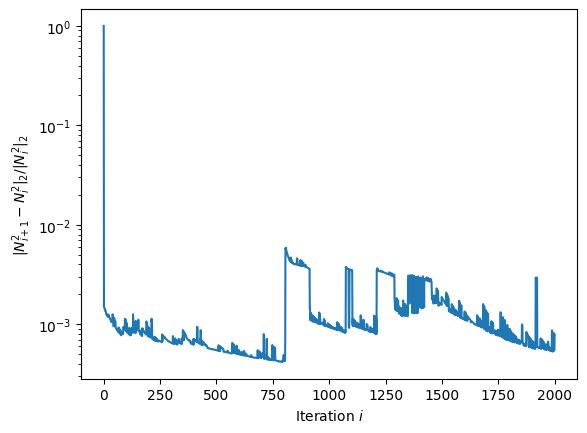

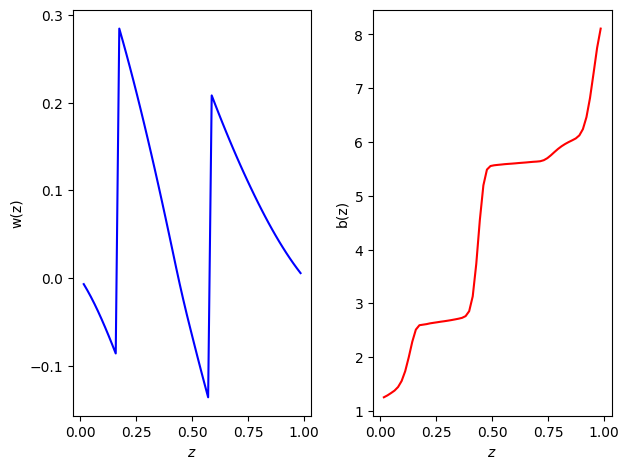

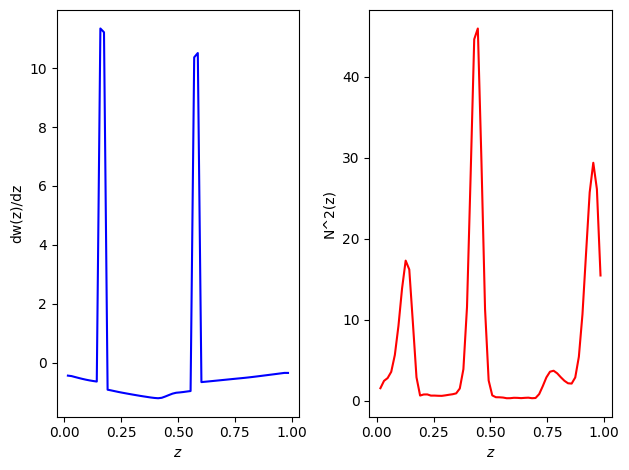

In [133]:
# Sources and IC
b      = 10*z #1*( (z**2)/2 - (z**3)/3 )
Nsq    = D@b;
#Plumes = {'F1':.5,'F2':-.5}
Plumes = {'F1':0.5,'F2':0.5,'F3':-1.0}
Area   = 1.0

σ     = 5e-04
dt    = 2.5e-03
A_inv = np.linalg.inv(I/dt - .5*σ*L)
B     = (I/dt + .5*σ*L)

Error = [1.0];
iter  = 0;
while (iter < 2*(10**3)): #(Error[-1] > 1e-03) or

  # (1) solve plume equations
  w = 0*z
  for F_key,F_value in Plumes.items():

    # Fixed buoyancy flux
    Q_i= Plume_Solve(F_value,Nsq)[1]

    # Distribution of buoyancy flux- Monte-Carlo
    #Q_i= Plume_Solve_Distribution(F_value,Nsq,samples = 10**2)[1]

    # Distribution of buoyancy flux - Fokker-Planck
    ##Q_i= Plume_Solve_Distribution(F_value,Nsq,samples = 10**2)[1]

    w -= Q_i/Area

  # (2) step db/dt forward
  b = step_buoyancy(w,b,σ=σ,dt=dt,A_inv=A_inv,B=B)

  # (3) update N^2 & check converged
  Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
  Nsq   = D@b;
  iter += 1.

  if iter%10 ==0:
    print('Iteration i = %d, Residual error r_i = %e \n'%(iter,Error[-1]))
    Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')
Plot_F_and_Q(D@w,Nsq,label_f='dw(z)/dz',label_q='N^2(z)')